## SVM - Usando diferenças

In [1]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score, mean_squared_error

import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

from sklearn.svm import SVR

from scipy import stats
from scipy.stats import boxcox

from xgboost import XGBRegressor

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from timeit import default_timer as timer
from dateutil.parser import parse
from datetime import datetime

import warnings

warnings.filterwarnings('ignore')

from IPython.display import display, Markdown
#get_ipython().run_line_magic('matplolib', 'inline')

pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)
pd.set_option('display.width', 800)
pd.set_option('display.max_colwidth', None)

pd.options.display.float_format = '{:.6f}'.format

plt.style.use('bmh')
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = '17'

### Funções Auxiliares

In [2]:
#Funções auxiliares

def sum_billion(x):    
    return round(((x.sum())/1000000000.0),2)

def sum_million(x):    
    return round(((x.sum())/1000000.0),2)

def sum_thousand(x):    
    return round(((x.sum())/1000.0),2)

def media_agregada(x):    

    return round(((x.sum())/12.0),0)

def ignore_nans(a,b):
    index = ~a.isnull() & ~b.isnull()
    return a[index], b[index]

#Função para avaliação de métricas de erros
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def smape(y_true,y_pred):
        num = np.abs(np.subtract(y_true,y_pred))
        den = (np.abs(y_true) + np.abs(y_pred)) / 2
        ratio = num/den
        return ratio.mean()

    print(f'Mean_Squared_Error_(MSE) is : {mean_squared_error(y_true,y_pred)}')
    print(f'Root_Mean_Squared_Error_(RMSE) is : {mean_squared_error(y_true,y_pred, squared=False)}')
    print(f'Mean_Absolute_Error_(MAE) is : {mean_absolute_error(y_true,y_pred)}')
    print(f'Mean_Absolute_Percentage_Error (MAPE) is : {mean_absolute_percentage_error(y_true,y_pred)}')
    print(f'Symmetrical_Mean_Absolute_Percentage_Error (sMAPE) is : {smape(y_true,y_pred)}')
    print(f'Coefficient of determination R^2 is : {r2_score(y_true,y_pred)}', end = '\n\n')

    df_evaluation_metrics = pd.DataFrame({'metrics': ['MSE','RMSE','MAE','MAPE','sMAPE','R^2'],
                                          'scores':[mean_squared_error(y_true,y_pred),
                                                    mean_squared_error(y_true,y_pred, squared=False),
                                                    mean_absolute_error(y_true,y_pred),
                                                    mean_absolute_percentage_error(y_true,y_pred),
                                                    smape(y_true,y_pred),
                                                    r2_score(y_true,y_pred)]})

    return df_evaluation_metrics

#Função para avaliação da estacionaridade dos dados da série temporal
def Augmented_Dickey_Fuller_Test_func(series, column_name):

    print(f'Results of Dickey-Fuller Test for column {column_name}')

    dftest = adfuller(series, autolag='AIC')

    dfoutput = pd.Series(dftest[0:4], index=[   'Test Statistic',
                                                'p-value',
                                                'No Lags Used',
                                                'Number of Observartions Used'])
    
    for key, value in dftest[4].items():
        
        dfoutput['Critical Value (%s)' %key] = value

    print(dfoutput)

    if dftest[1] <= 0.05:
        print('Conclusion:====>')
        print('Reject the null hypothesis')
        print('Data is stationary')
    else:
        print('Conclusion:====>')
        print('Fail to reject the null hypothesis')
        print('Data is non-stationary')


def inverse_diff(actual_df, pred_df):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns:
        df_res[col + '_1st_inv_diff'] = actual_df[col].iloc[-1] + df_res[col].cumsum()
    return df_res

### Carregamento e leitura dos dados

In [3]:
grupo = 'Adesão - Grande - Cooperativa Médica' 

grupo_csv = "ade_g_coopmed.csv"

#path = r'D:\TCC\TCC\codigos\preparacao_dados\analise_agrupadas\adesao\porte_grande\adesao_grande_cooperativa_medica' + '\\' + grupo_csv

ans = pd.read_csv(grupo_csv, sep=';', decimal= ',', encoding='mbcs')

#Amostra do dataframe
ans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 616 entries, 0 to 615
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ano          616 non-null    int64  
 1   cd_ops       616 non-null    int64  
 2   trimestre    616 non-null    object 
 3   receita      616 non-null    float64
 4   despesa      616 non-null    float64
 5   benef        616 non-null    int64  
 6   modalidade   616 non-null    object 
 7   port_ops     616 non-null    object 
 8   contratacao  616 non-null    object 
dtypes: float64(2), int64(3), object(4)
memory usage: 43.4+ KB


In [4]:
ind_econ = 'ind_econ.csv'

df_ind_econ = pd.read_csv(ind_econ, sep=';', decimal= ',', encoding='mbcs')

df_ind_econ = df_ind_econ[(df_ind_econ.trimestre > '2017Q4') & (df_ind_econ.trimestre < '2022Q1')]

df_ind_econ = df_ind_econ.reset_index(drop=True)

df_ind_econ['trimestre'] = pd.PeriodIndex(df_ind_econ['trimestre'], freq="Q")

df_ind_econ['PNAD'] = df_ind_econ['PNAD'].astype('float') 

df_ind_econ['Dolar_diff'] = df_ind_econ['Dolar'].diff(1)

df_ind_econ['PNAD_diff'] = df_ind_econ['PNAD'].diff(1) 

df_ind_econ.info()

df_ind_econ

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype        
---  ------      --------------  -----        
 0   trimestre   16 non-null     period[Q-DEC]
 1   IPCA        16 non-null     float64      
 2   Selic       16 non-null     float64      
 3   Dolar       16 non-null     float64      
 4   PNAD        16 non-null     float64      
 5   Dolar_diff  15 non-null     float64      
 6   PNAD_diff   15 non-null     float64      
dtypes: float64(6), period[Q-DEC](1)
memory usage: 1.0 KB


,trimestre,IPCA,Selic,Dolar,PNAD,Dolar_diff,PNAD_diff
0,2018Q1,0.007015,0.000158,3.245100,4285.000000,NaN,NaN
1,2018Q2,0.018887,0.000156,3.457233,4279.000000,0.212133,-6.000000
2,2018Q3,0.007209,0.000158,3.853900,4329.000000,0.396667,50.000000
3,2018Q4,0.003894,0.000152,3.904500,4424.000000,0.050600,95.000000
4,2019Q1,0.015070,0.000150,3.776467,4419.000000,-0.128033,-5.000000
5,2019Q2,0.007108,0.000153,3.903500,4327.000000,0.127033,-92.000000
6,2019Q3,0.002601,0.000153,3.882133,4286.000000,-0.021367,-41.000000
7,2019Q4,0.017675,0.000123,4.131167,4410.000000,0.249034,124.000000
8,2020Q1,0.005308,0.000101,4.191133,4355.000000,0.059966,-55.000000
9,2020Q2,-0.004306,0.000073,5.272333,4009.000000,1.081200,-346.000000


In [5]:
ans_agrup = ans.groupby(['ano','trimestre'], as_index=False).agg({  'receita':lambda x: sum_billion(x),
                                                                    'despesa':lambda x: sum_billion(x),
                                                                    'benef': 'sum',
                                                                    'cd_ops':lambda x: x.nunique()})

ans_agrup['pct_despesa'] = ans_agrup.apply(lambda x: (x['despesa']/x['receita'])*100 , axis = 1).round(2)

ans_agrup.columns = ['ano','trimestre','receita','despesa','benef','n_ops','pct_despesa']

ans_agrup = ans_agrup[['trimestre','receita','despesa','benef','n_ops','pct_despesa']]

ans_agrup = ans_agrup[(ans_agrup.trimestre > '2017Q4') & (ans_agrup.trimestre < '2022Q1')]

ans_agrup[['n_ops','benef']] = ans_agrup[['n_ops','benef']].astype('int')

ans_agrup['ano'] = ans_agrup['trimestre'].str[:4]

ans_agrup['ano'] = ans_agrup['ano'].astype('int')

ans_agrup['n_tri'] = ans_agrup['trimestre'].str[-1:]

ans_agrup['n_tri'] = ans_agrup['n_tri'].astype('float')

ans_agrup['n_tri_l1'] = ans_agrup['n_tri'].shift(1)

ans_agrup['trimestre'] = pd.PeriodIndex(ans_agrup['trimestre'], freq="Q")

#Tratamento dados benef

ans_agrup['benefm'] = ans_agrup['benef'] / 3.0

ans_agrup['benefm_diff'] = ans_agrup['benefm'].diff(1)
ans_agrup['benefm_diff_l1'] = ans_agrup['benefm_diff'].shift(1)
ans_agrup['benefm_diff_l2'] = ans_agrup['benefm_diff'].shift(2)

ans_agrup['benefm_diff2'] = ans_agrup['benefm_diff'].diff(1)
ans_agrup['benefm_diff2_l1'] = ans_agrup['benefm_diff2'].shift(1)
ans_agrup['benefm_diff2_l2'] = ans_agrup['benefm_diff2'].shift(2)


#Tratamento dados receita
ans_agrup['receita_l1'] = ans_agrup['receita'].shift(1)
ans_agrup['receita_l2'] = ans_agrup['receita'].shift(2)

ans_agrup['receita_diff'] = ans_agrup['receita'].diff(1)
ans_agrup['receita_diff_l1'] = ans_agrup['receita_diff'].shift(1)
ans_agrup['receita_diff_l2'] = ans_agrup['receita_diff'].shift(2)

ans_agrup['receita_diff2'] = ans_agrup['receita_diff'].diff(1)
ans_agrup['receita_diff2_l1'] = ans_agrup['receita_diff2'].shift(1)
ans_agrup['receita_diff2_l2'] = ans_agrup['receita_diff2'].shift(2)


#Tratamento dados despesa

ans_agrup['despesa_l1'] = ans_agrup['despesa'].shift(1)
ans_agrup['despesa_l2'] = ans_agrup['despesa'].shift(2)

ans_agrup['despesa_diff'] = ans_agrup['despesa'].diff(1)
ans_agrup['despesa_diff_l1'] = ans_agrup['despesa_diff'].shift(1)
ans_agrup['despesa_diff_l2'] = ans_agrup['despesa_diff'].shift(2)

ans_agrup['despesa_diff2'] = ans_agrup['despesa_diff'].diff(1)
ans_agrup['despesa_diff2_l1'] = ans_agrup['despesa_diff2'].shift(1)
ans_agrup['despesa_diff2_l2'] = ans_agrup['despesa_diff2'].shift(2)

#Variáveis Dummies

#ans_agrup['dmy_outlier'] = np.where(ans_agrup['trimestre'] == '2019Q1',0.0,1.0)

ans_agrup['dmy_covid'] = np.where((ans_agrup['trimestre'] >= '2020Q1') & (ans_agrup['trimestre'] <= '2020Q3'),0.0,1.0)

ans_agrup['dmy_n_ops'] = np.where((ans_agrup['trimestre'] == '2020Q1'),1.0,0.0)

ans_agrup.info()

ans_agrup

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16 entries, 0 to 15
Data columns (total 34 columns):
 #   Column            Non-Null Count  Dtype        
---  ------            --------------  -----        
 0   trimestre         16 non-null     period[Q-DEC]
 1   receita           16 non-null     float64      
 2   despesa           16 non-null     float64      
 3   benef             16 non-null     int32        
 4   n_ops             16 non-null     int32        
 5   pct_despesa       16 non-null     float64      
 6   ano               16 non-null     int32        
 7   n_tri             16 non-null     float64      
 8   n_tri_l1          15 non-null     float64      
 9   benefm            16 non-null     float64      
 10  benefm_diff       15 non-null     float64      
 11  benefm_diff_l1    14 non-null     float64      
 12  benefm_diff_l2    13 non-null     float64      
 13  benefm_diff2      14 non-null     float64      
 14  benefm_diff2_l1   13 non-null     float64   

,trimestre,receita,despesa,benef,n_ops,pct_despesa,ano,n_tri,n_tri_l1,benefm,benefm_diff,benefm_diff_l1,benefm_diff_l2,benefm_diff2,benefm_diff2_l1,benefm_diff2_l2,receita_l1,receita_l2,receita_diff,receita_diff_l1,receita_diff_l2,receita_diff2,receita_diff2_l1,receita_diff2_l2,despesa_l1,despesa_l2,despesa_diff,despesa_diff_l1,despesa_diff_l2,despesa_diff2,despesa_diff2_l1,despesa_diff2_l2,dmy_covid,dmy_n_ops
0,2018Q1,2.150000,1.580000,1655264,38,73.490000,2018,1.000000,NaN,551754.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000
1,2018Q2,2.160000,1.640000,1667369,38,75.930000,2018,2.000000,1.000000,555789.666667,4035.000000,NaN,NaN,NaN,NaN,NaN,2.150000,NaN,0.010000,NaN,NaN,NaN,NaN,NaN,1.580000,NaN,0.060000,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000
2,2018Q3,2.290000,1.850000,1678692,38,80.790000,2018,3.000000,2.000000,559564.000000,3774.333333,4035.000000,NaN,-260.666667,NaN,NaN,2.160000,2.150000,0.130000,0.010000,NaN,0.120000,NaN,NaN,1.640000,1.580000,0.210000,0.060000,NaN,0.150000,NaN,NaN,1.000000,0.000000
3,2018Q4,2.380000,1.250000,1693379,38,52.520000,2018,4.000000,3.000000,564459.666667,4895.666667,3774.333333,4035.000000,1121.333333,-260.666667,NaN,2.290000,2.160000,0.090000,0.130000,0.010000,-0.040000,0.120000,NaN,1.850000,1.640000,-0.600000,0.210000,0.060000,-0.810000,0.150000,NaN,1.000000,0.000000
4,2019Q1,2.370000,1.870000,1700602,38,78.900000,2019,1.000000,4.000000,566867.333333,2407.666667,4895.666667,3774.333333,-2488.000000,1121.333333,-260.666667,2.380000,2.290000,-0.010000,0.090000,0.130000,-0.100000,-0.040000,0.120000,1.250000,1.850000,0.620000,-0.600000,0.210000,1.220000,-0.810000,0.150000,1.000000,0.000000
5,2019Q2,2.460000,1.980000,1730500,38,80.490000,2019,2.000000,1.000000,576833.333333,9966.000000,2407.666667,4895.666667,7558.333333,-2488.000000,1121.333333,2.370000,2.380000,0.090000,-0.010000,0.090000,0.100000,-0.100000,-0.040000,1.870000,1.250000,0.110000,0.620000,-0.600000,-0.510000,1.220000,-0.810000,1.000000,0.000000
6,2019Q3,2.550000,1.950000,1733529,38,76.470000,2019,3.000000,2.000000,577843.000000,1009.666667,9966.000000,2407.666667,-8956.333333,7558.333333,-2488.000000,2.460000,2.370000,0.090000,0.090000,-0.010000,0.000000,0.100000,-0.100000,1.980000,1.870000,-0.030000,0.110000,0.620000,-0.140000,-0.510000,1.220000,1.000000,0.000000
7,2019Q4,2.650000,2.080000,1757501,38,78.490000,2019,4.000000,3.000000,585833.666667,7990.666667,1009.666667,9966.000000,6981.000000,-8956.333333,7558.333333,2.550000,2.460000,0.100000,0.090000,0.090000,0.010000,0.000000,0.100000,1.950000,1.980000,0.130000,-0.030000,0.110000,0.160000,-0.140000,-0.510000,1.000000,0.000000
8,2020Q1,2.750000,2.100000,1876410,39,76.360000,2020,1.000000,4.000000,625470.000000,39636.333333,7990.666667,1009.666667,31645.666667,6981.000000,-8956.333333,2.650000,2.550000,0.100000,0.100000,0.090000,0.000000,0.010000,0.000000,2.080000,1.950000,0.020000,0.130000,-0.030000,-0.110000,0.160000,-0.140000,0.000000,1.000000
9,2020Q2,2.790000,1.750000,1892513,39,62.720000,2020,2.000000,1.000000,630837.666667,5367.666667,39636.333333,7990.666667,-34268.666667,31645.666667,6981.000000,2.750000,2.650000,0.040000,0.100000,0.100000,-0.060000,0.000000,0.010000,2.100000,2.080000,-0.350000,0.020000,0.130000,-0.370000,-0.110000,0.160000,0.000000,0.000000


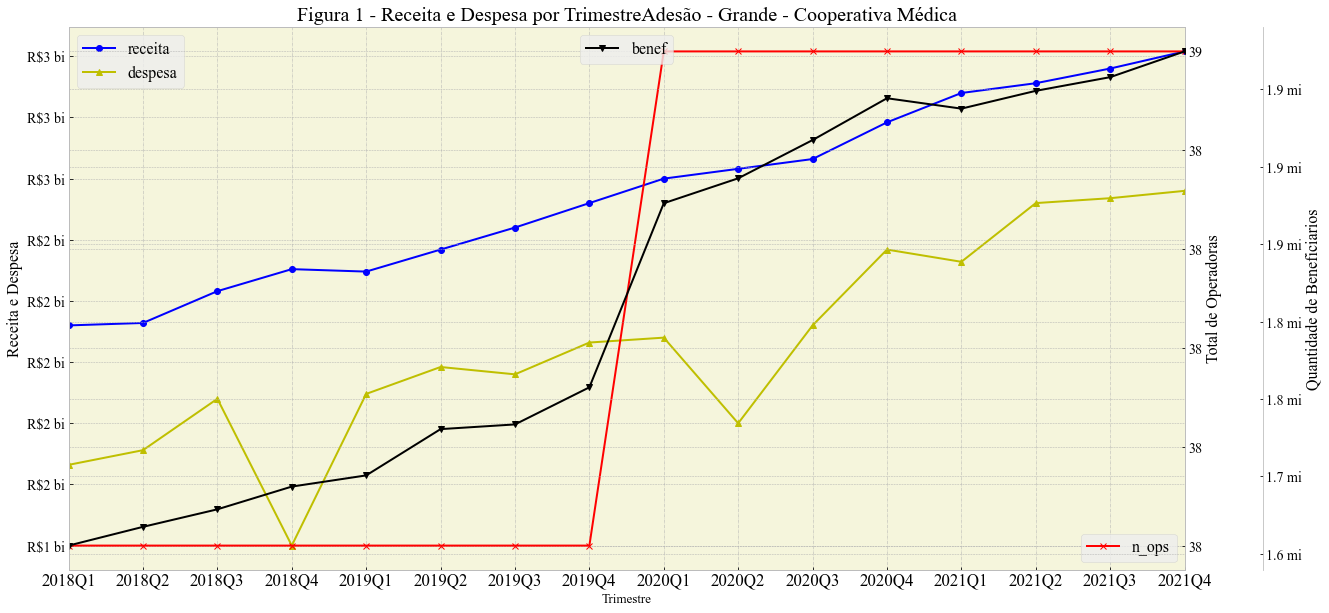

In [6]:
df_plot = ans_agrup.copy()

df_plot.set_index('trimestre', inplace=True)

fig,ax1 = plt.subplots()

df_plot.plot(y=['receita','despesa'],figsize=(20, 10), style=['bo-','y^-'], ax=ax1)
ax1.set_title('Figura 1 - Receita e Despesa por Trimestre' + grupo,fontsize = 20)
ax1.set_xticks(df_plot.index)
ax1.set_xticklabels(df_plot.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} bi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita e Despesa', fontsize=16)
ax1.legend(loc = 'upper left', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')

ax2 = ax1.twinx()

df_plot.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(df_plot.index)
ax2.set_xticklabels(df_plot.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
yticks = ax2.get_yticks()
ax2.set_yticklabels(yticks.astype(int), fontsize = 14)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'lower right', fontsize = 16)

ax3 = ax1.twinx()

ax3.spines.right.set_position(("axes", 1.07))

df_plot.plot(y=['benef'], figsize=(20,10), style=['kv-'], ax=ax3)
ax3.set_xticks(df_plot.index)
ax3.set_xticklabels(df_plot.index)
ax3.set_xlabel('Trimestre', fontsize = 13)
yticks = ax3.get_yticks()
ax3.set_yticklabels(['{:.1f} mi'.format(x/1e6) for x in yticks], fontsize = 14)
ax3.set_ylabel('Quantidade de Beneficiarios', fontsize=16)
ax3.legend(loc = 'upper center', fontsize = 16)

plt.show()

del df_plot

In [7]:
ans_agrup = ans_agrup.merge(df_ind_econ, how='left', on='trimestre')

ans_agrup

,trimestre,receita,despesa,benef,n_ops,pct_despesa,ano,n_tri,n_tri_l1,benefm,benefm_diff,benefm_diff_l1,benefm_diff_l2,benefm_diff2,benefm_diff2_l1,benefm_diff2_l2,receita_l1,receita_l2,receita_diff,receita_diff_l1,receita_diff_l2,receita_diff2,receita_diff2_l1,receita_diff2_l2,despesa_l1,despesa_l2,despesa_diff,despesa_diff_l1,despesa_diff_l2,despesa_diff2,despesa_diff2_l1,despesa_diff2_l2,dmy_covid,dmy_n_ops,IPCA,Selic,Dolar,PNAD,Dolar_diff,PNAD_diff
0,2018Q1,2.150000,1.580000,1655264,38,73.490000,2018,1.000000,NaN,551754.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000,0.007015,0.000158,3.245100,4285.000000,NaN,NaN
1,2018Q2,2.160000,1.640000,1667369,38,75.930000,2018,2.000000,1.000000,555789.666667,4035.000000,NaN,NaN,NaN,NaN,NaN,2.150000,NaN,0.010000,NaN,NaN,NaN,NaN,NaN,1.580000,NaN,0.060000,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000,0.018887,0.000156,3.457233,4279.000000,0.212133,-6.000000
2,2018Q3,2.290000,1.850000,1678692,38,80.790000,2018,3.000000,2.000000,559564.000000,3774.333333,4035.000000,NaN,-260.666667,NaN,NaN,2.160000,2.150000,0.130000,0.010000,NaN,0.120000,NaN,NaN,1.640000,1.580000,0.210000,0.060000,NaN,0.150000,NaN,NaN,1.000000,0.000000,0.007209,0.000158,3.853900,4329.000000,0.396667,50.000000
3,2018Q4,2.380000,1.250000,1693379,38,52.520000,2018,4.000000,3.000000,564459.666667,4895.666667,3774.333333,4035.000000,1121.333333,-260.666667,NaN,2.290000,2.160000,0.090000,0.130000,0.010000,-0.040000,0.120000,NaN,1.850000,1.640000,-0.600000,0.210000,0.060000,-0.810000,0.150000,NaN,1.000000,0.000000,0.003894,0.000152,3.904500,4424.000000,0.050600,95.000000
4,2019Q1,2.370000,1.870000,1700602,38,78.900000,2019,1.000000,4.000000,566867.333333,2407.666667,4895.666667,3774.333333,-2488.000000,1121.333333,-260.666667,2.380000,2.290000,-0.010000,0.090000,0.130000,-0.100000,-0.040000,0.120000,1.250000,1.850000,0.620000,-0.600000,0.210000,1.220000,-0.810000,0.150000,1.000000,0.000000,0.015070,0.000150,3.776467,4419.000000,-0.128033,-5.000000
5,2019Q2,2.460000,1.980000,1730500,38,80.490000,2019,2.000000,1.000000,576833.333333,9966.000000,2407.666667,4895.666667,7558.333333,-2488.000000,1121.333333,2.370000,2.380000,0.090000,-0.010000,0.090000,0.100000,-0.100000,-0.040000,1.870000,1.250000,0.110000,0.620000,-0.600000,-0.510000,1.220000,-0.810000,1.000000,0.000000,0.007108,0.000153,3.903500,4327.000000,0.127033,-92.000000
6,2019Q3,2.550000,1.950000,1733529,38,76.470000,2019,3.000000,2.000000,577843.000000,1009.666667,9966.000000,2407.666667,-8956.333333,7558.333333,-2488.000000,2.460000,2.370000,0.090000,0.090000,-0.010000,0.000000,0.100000,-0.100000,1.980000,1.870000,-0.030000,0.110000,0.620000,-0.140000,-0.510000,1.220000,1.000000,0.000000,0.002601,0.000153,3.882133,4286.000000,-0.021367,-41.000000
7,2019Q4,2.650000,2.080000,1757501,38,78.490000,2019,4.000000,3.000000,585833.666667,7990.666667,1009.666667,9966.000000,6981.000000,-8956.333333,7558.333333,2.550000,2.460000,0.100000,0.090000,0.090000,0.010000,0.000000,0.100000,1.950000,1.980000,0.130000,-0.030000,0.110000,0.160000,-0.140000,-0.510000,1.000000,0.000000,0.017675,0.000123,4.131167,4410.000000,0.249034,124.000000
8,2020Q1,2.750000,2.100000,1876410,39,76.360000,2020,1.000000,4.000000,625470.000000,39636.333333,7990.666667,1009.666667,31645.666667,6981.000000,-8956.333333,2.650000,2.550000,0.100000,0.100000,0.090000,0.000000,0.010000,0.000000,2.080000,1.950000,0.020000,0.130000,-0.030000,-0.110000,0.160000,-0.140000,0.000000,1.000000,0.005308,0.000101,4.191133,4355.000000,0.059966,-55.000000
9,2020Q2,2.790000,1.750000,1892513,39,62.720000,2020,2.000000,1.000000,630837.666667,5367.666667,39636.333333,7990.666667,-34268.666667,31645.666667,6981.000000,2.750000,2.650000,0.040000,0.100000,0.100000,-0.060000,0.000000,0.010000,2.100000,2.080000,-0.350000,0.020000,0.130000,-0.370000,-0.110000,0.160000,0.000000,0.000000,-0.004306,0.000073,5.272333,4009.000000,1.081200,-346.000000


In [8]:
ans_agrup.set_index('trimestre', inplace=True)

ans_agrup_full = ans_agrup.copy()

In [9]:
ans_agrup = ans_agrup.dropna()

#informações sobre o data frame
ans_agrup.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 12 entries, 2019Q1 to 2021Q4
Freq: Q-DEC
Data columns (total 39 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   receita           12 non-null     float64
 1   despesa           12 non-null     float64
 2   benef             12 non-null     int32  
 3   n_ops             12 non-null     int32  
 4   pct_despesa       12 non-null     float64
 5   ano               12 non-null     int32  
 6   n_tri             12 non-null     float64
 7   n_tri_l1          12 non-null     float64
 8   benefm            12 non-null     float64
 9   benefm_diff       12 non-null     float64
 10  benefm_diff_l1    12 non-null     float64
 11  benefm_diff_l2    12 non-null     float64
 12  benefm_diff2      12 non-null     float64
 13  benefm_diff2_l1   12 non-null     float64
 14  benefm_diff2_l2   12 non-null     float64
 15  receita_l1        12 non-null     float64
 16  receita_l2        12 non

In [10]:
columns_receita = ['receita', 'receita_diff', 'despesa', 'despesa_diff', 'benefm', 'benefm_diff']

ans_agrup

,receita,despesa,benef,n_ops,pct_despesa,ano,n_tri,n_tri_l1,benefm,benefm_diff,benefm_diff_l1,benefm_diff_l2,benefm_diff2,benefm_diff2_l1,benefm_diff2_l2,receita_l1,receita_l2,receita_diff,receita_diff_l1,receita_diff_l2,receita_diff2,receita_diff2_l1,receita_diff2_l2,despesa_l1,despesa_l2,despesa_diff,despesa_diff_l1,despesa_diff_l2,despesa_diff2,despesa_diff2_l1,despesa_diff2_l2,dmy_covid,dmy_n_ops,IPCA,Selic,Dolar,PNAD,Dolar_diff,PNAD_diff
trimestre,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019Q1,2.370000,1.870000,1700602,38,78.900000,2019,1.000000,4.000000,566867.333333,2407.666667,4895.666667,3774.333333,-2488.000000,1121.333333,-260.666667,2.380000,2.290000,-0.010000,0.090000,0.130000,-0.100000,-0.040000,0.120000,1.250000,1.850000,0.620000,-0.600000,0.210000,1.220000,-0.810000,0.150000,1.000000,0.000000,0.015070,0.000150,3.776467,4419.000000,-0.128033,-5.000000
2019Q2,2.460000,1.980000,1730500,38,80.490000,2019,2.000000,1.000000,576833.333333,9966.000000,2407.666667,4895.666667,7558.333333,-2488.000000,1121.333333,2.370000,2.380000,0.090000,-0.010000,0.090000,0.100000,-0.100000,-0.040000,1.870000,1.250000,0.110000,0.620000,-0.600000,-0.510000,1.220000,-0.810000,1.000000,0.000000,0.007108,0.000153,3.903500,4327.000000,0.127033,-92.000000
2019Q3,2.550000,1.950000,1733529,38,76.470000,2019,3.000000,2.000000,577843.000000,1009.666667,9966.000000,2407.666667,-8956.333333,7558.333333,-2488.000000,2.460000,2.370000,0.090000,0.090000,-0.010000,0.000000,0.100000,-0.100000,1.980000,1.870000,-0.030000,0.110000,0.620000,-0.140000,-0.510000,1.220000,1.000000,0.000000,0.002601,0.000153,3.882133,4286.000000,-0.021367,-41.000000
2019Q4,2.650000,2.080000,1757501,38,78.490000,2019,4.000000,3.000000,585833.666667,7990.666667,1009.666667,9966.000000,6981.000000,-8956.333333,7558.333333,2.550000,2.460000,0.100000,0.090000,0.090000,0.010000,0.000000,0.100000,1.950000,1.980000,0.130000,-0.030000,0.110000,0.160000,-0.140000,-0.510000,1.000000,0.000000,0.017675,0.000123,4.131167,4410.000000,0.249034,124.000000
2020Q1,2.750000,2.100000,1876410,39,76.360000,2020,1.000000,4.000000,625470.000000,39636.333333,7990.666667,1009.666667,31645.666667,6981.000000,-8956.333333,2.650000,2.550000,0.100000,0.100000,0.090000,0.000000,0.010000,0.000000,2.080000,1.950000,0.020000,0.130000,-0.030000,-0.110000,0.160000,-0.140000,0.000000,1.000000,0.005308,0.000101,4.191133,4355.000000,0.059966,-55.000000
2020Q2,2.790000,1.750000,1892513,39,62.720000,2020,2.000000,1.000000,630837.666667,5367.666667,39636.333333,7990.666667,-34268.666667,31645.666667,6981.000000,2.750000,2.650000,0.040000,0.100000,0.100000,-0.060000,0.000000,0.010000,2.100000,2.080000,-0.350000,0.020000,0.130000,-0.370000,-0.110000,0.160000,0.000000,0.000000,-0.004306,0.000073,5.272333,4009.000000,1.081200,-346.000000
2020Q3,2.830000,2.150000,1917215,39,75.970000,2020,3.000000,2.000000,639071.666667,8234.000000,5367.666667,39636.333333,2866.333333,-34268.666667,31645.666667,2.790000,2.750000,0.040000,0.040000,0.100000,0.000000,-0.060000,0.000000,1.750000,2.100000,0.400000,-0.350000,0.020000,0.750000,-0.370000,-0.110000,0.000000,0.000000,0.012447,0.000051,5.307533,3837.000000,0.035200,-172.000000
2020Q4,2.980000,2.460000,1944236,39,82.550000,2020,4.000000,3.000000,648078.666667,9007.000000,8234.000000,5367.666667,773.000000,2866.333333,-34268.666667,2.830000,2.790000,0.150000,0.040000,0.040000,0.110000,0.000000,-0.060000,2.150000,1.750000,0.310000,0.400000,-0.350000,-0.090000,0.750000,-0.370000,1.000000,0.000000,0.031314,0.000047,5.458467,3841.000000,0.150934,4.000000
2021Q1,3.100000,2.410000,1937524,39,77.740000,2021,1.000000,4.000000,645841.333333,-2237.333333,9007.000000,8234.000000,-11244.333333,773.000000,2866.333333,2.980000,2.830000,0.120000,0.150000,0.040000,-0.030000,0.110000,0.000000,2.460000,2.150000,-0.050000,0.310000,0.400000,-0.360000,-0.090000,0.750000,1.000000,0.000000,0.020525,0.000048,5.249900,3760.000000,-0.208567,-81.000000


receita


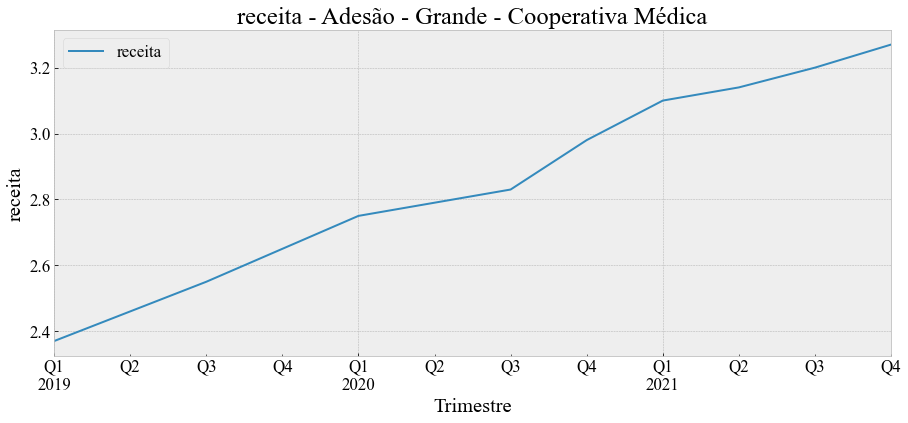

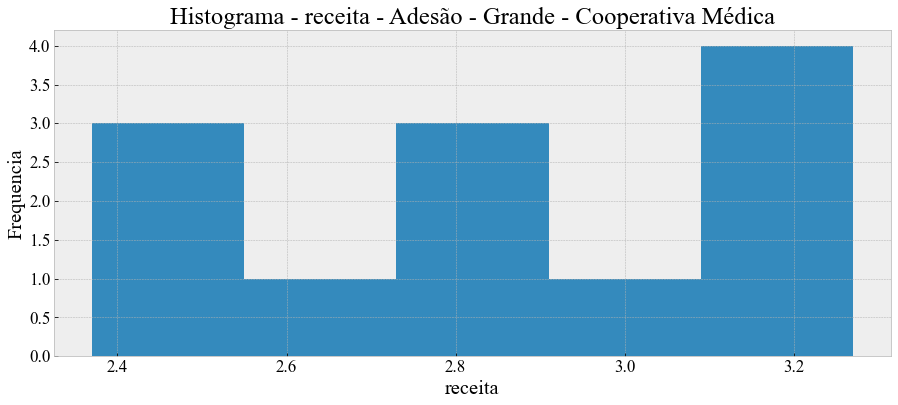

receita_diff


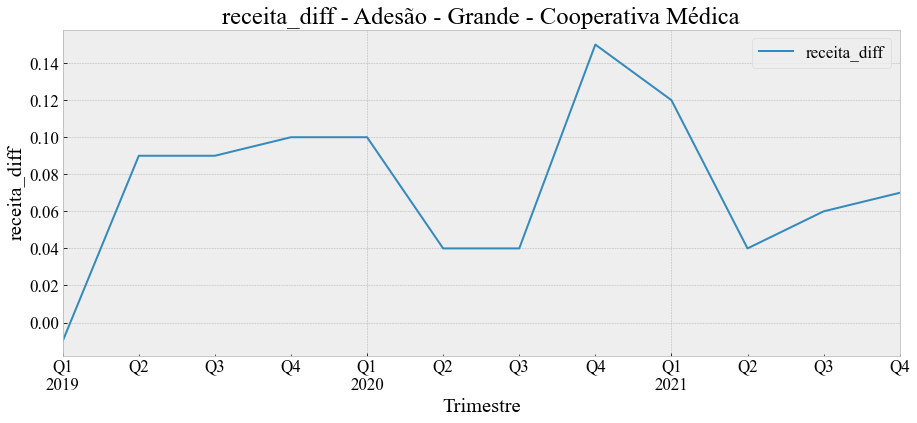

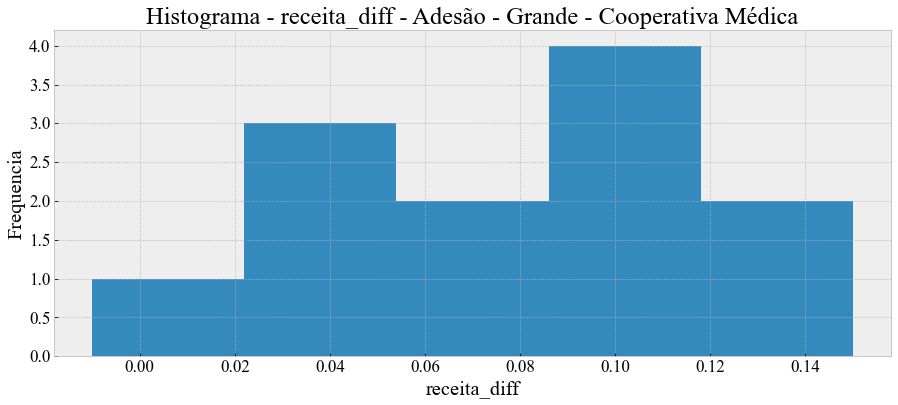

despesa


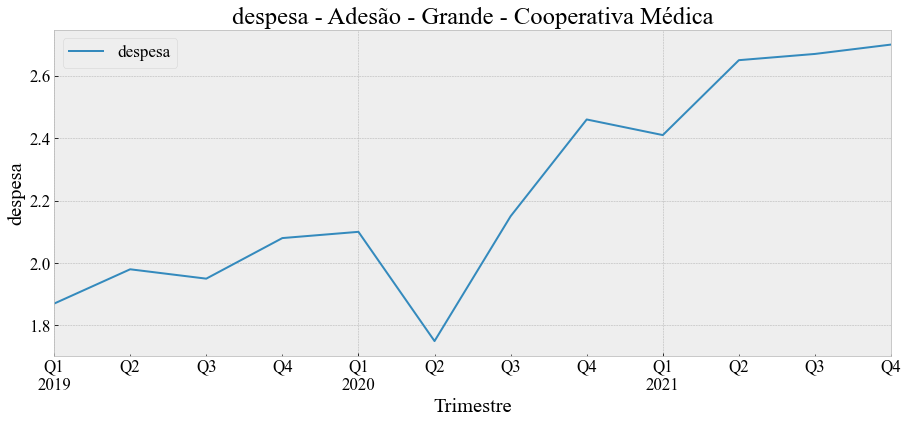

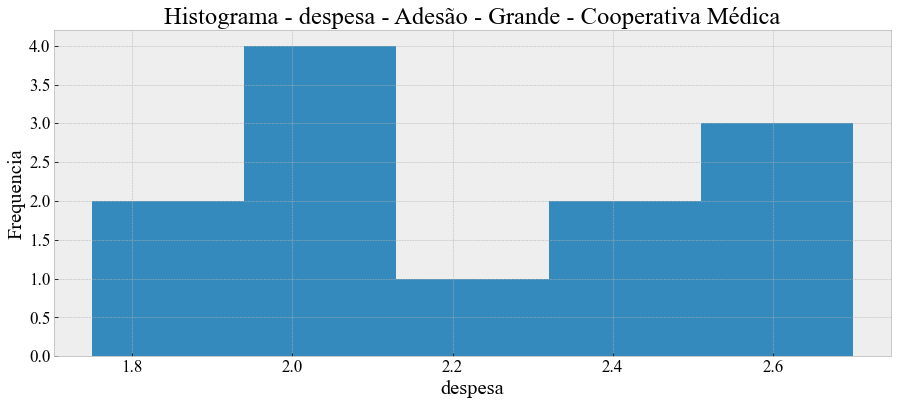

despesa_diff


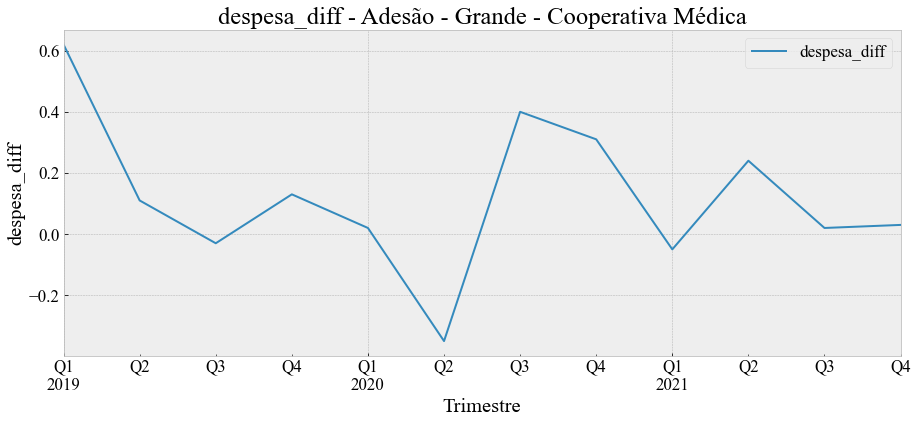

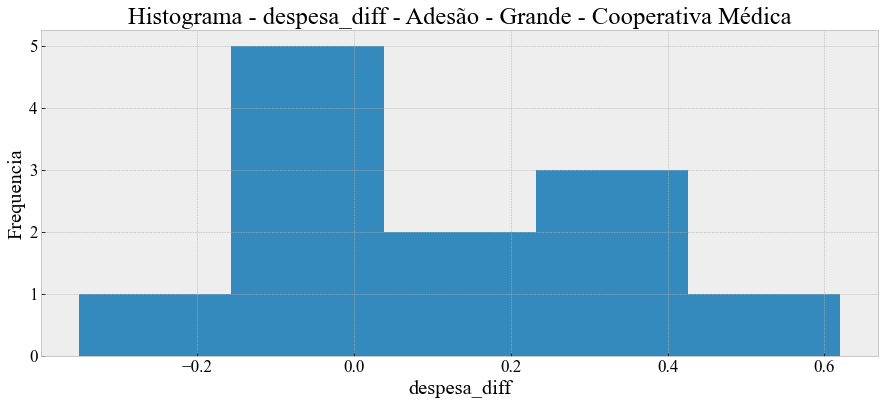

benefm


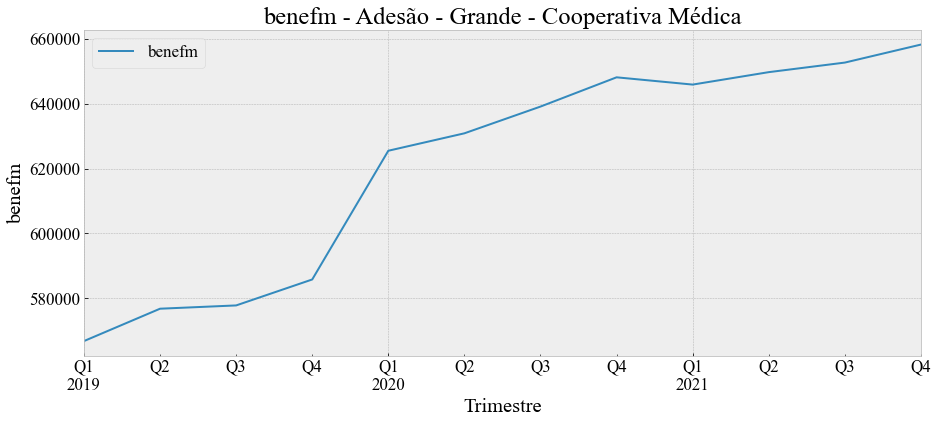

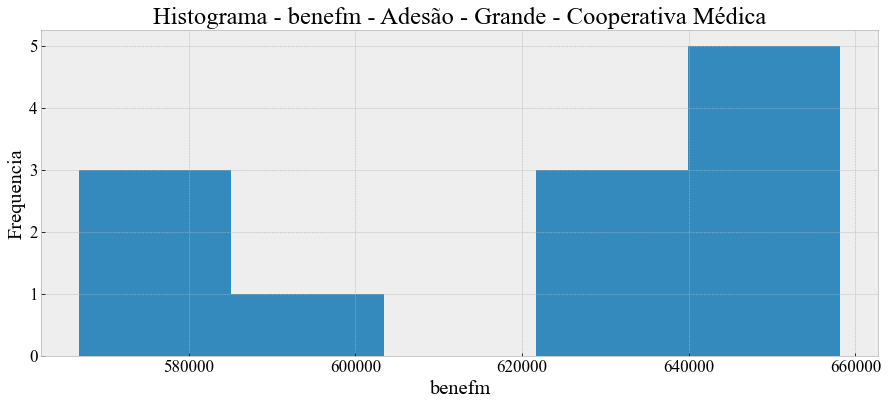

benefm_diff


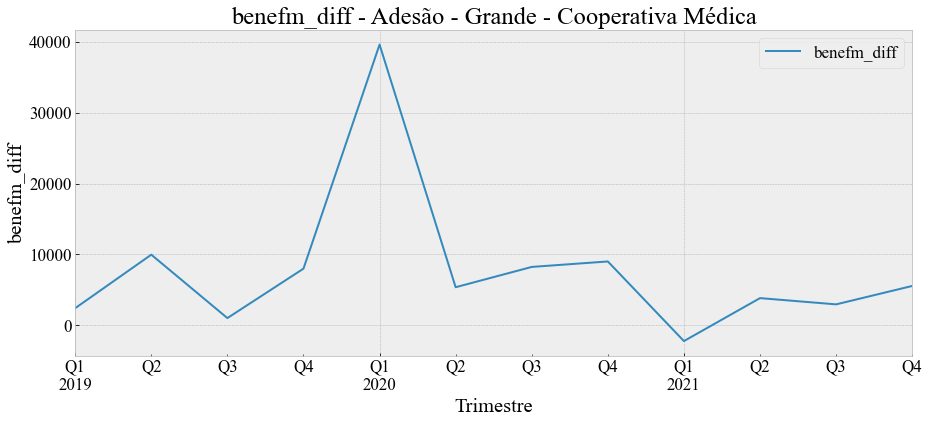

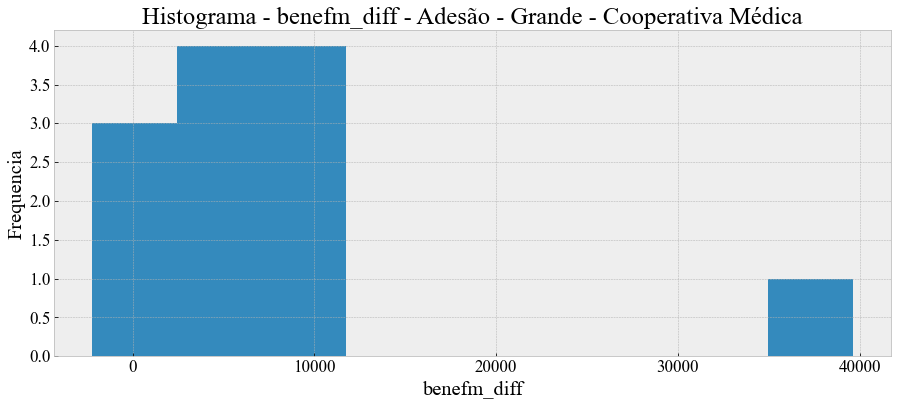

In [11]:
for c in ans_agrup[columns_receita]:
    print(str(c))

    ans_agrup.plot(y = str(c), figsize=(15,6))
    plt.xlabel('Trimestre')
    plt.ylabel(c)
    plt.title(f'{str(c)} - '+ grupo)
    plt.show()

    ans_agrup[str(c)].hist(bins='auto',figsize=(15,6))
    plt.xlabel(str(c))
    plt.ylabel('Frequencia')
    plt.title(f'Histograma - {str(c)} - '+ grupo)
    plt.show()

## 1 Etapa -  Forecast da benef - Random Forest

In [12]:
ans_agrup_benefm = ans_agrup_full[['n_tri','n_tri_l1','benefm','benefm_diff','benefm_diff2','benefm_diff_l1','benefm_diff2_l1',
                                   'IPCA','Selic','Dolar','Dolar_diff','PNAD','PNAD_diff','dmy_covid','dmy_n_ops']]

ans_agrup_benefm = ans_agrup_benefm.dropna()

display(ans_agrup_benefm.info())

ans_agrup_benefm

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 13 entries, 2018Q4 to 2021Q4
Freq: Q-DEC
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   n_tri            13 non-null     float64
 1   n_tri_l1         13 non-null     float64
 2   benefm           13 non-null     float64
 3   benefm_diff      13 non-null     float64
 4   benefm_diff2     13 non-null     float64
 5   benefm_diff_l1   13 non-null     float64
 6   benefm_diff2_l1  13 non-null     float64
 7   IPCA             13 non-null     float64
 8   Selic            13 non-null     float64
 9   Dolar            13 non-null     float64
 10  Dolar_diff       13 non-null     float64
 11  PNAD             13 non-null     float64
 12  PNAD_diff        13 non-null     float64
 13  dmy_covid        13 non-null     float64
 14  dmy_n_ops        13 non-null     float64
dtypes: float64(15)
memory usage: 1.6 KB


None

,n_tri,n_tri_l1,benefm,benefm_diff,benefm_diff2,benefm_diff_l1,benefm_diff2_l1,IPCA,Selic,Dolar,Dolar_diff,PNAD,PNAD_diff,dmy_covid,dmy_n_ops
trimestre,,,,,,,,,,,,,,,
2018Q4,4.000000,3.000000,564459.666667,4895.666667,1121.333333,3774.333333,-260.666667,0.003894,0.000152,3.904500,0.050600,4424.000000,95.000000,1.000000,0.000000
2019Q1,1.000000,4.000000,566867.333333,2407.666667,-2488.000000,4895.666667,1121.333333,0.015070,0.000150,3.776467,-0.128033,4419.000000,-5.000000,1.000000,0.000000
2019Q2,2.000000,1.000000,576833.333333,9966.000000,7558.333333,2407.666667,-2488.000000,0.007108,0.000153,3.903500,0.127033,4327.000000,-92.000000,1.000000,0.000000
2019Q3,3.000000,2.000000,577843.000000,1009.666667,-8956.333333,9966.000000,7558.333333,0.002601,0.000153,3.882133,-0.021367,4286.000000,-41.000000,1.000000,0.000000
2019Q4,4.000000,3.000000,585833.666667,7990.666667,6981.000000,1009.666667,-8956.333333,0.017675,0.000123,4.131167,0.249034,4410.000000,124.000000,1.000000,0.000000
2020Q1,1.000000,4.000000,625470.000000,39636.333333,31645.666667,7990.666667,6981.000000,0.005308,0.000101,4.191133,0.059966,4355.000000,-55.000000,0.000000,1.000000
2020Q2,2.000000,1.000000,630837.666667,5367.666667,-34268.666667,39636.333333,31645.666667,-0.004306,0.000073,5.272333,1.081200,4009.000000,-346.000000,0.000000,0.000000
2020Q3,3.000000,2.000000,639071.666667,8234.000000,2866.333333,5367.666667,-34268.666667,0.012447,0.000051,5.307533,0.035200,3837.000000,-172.000000,0.000000,0.000000
2020Q4,4.000000,3.000000,648078.666667,9007.000000,773.000000,8234.000000,2866.333333,0.031314,0.000047,5.458467,0.150934,3841.000000,4.000000,1.000000,0.000000


In [13]:
#Create X and y object
X_benefm = ans_agrup_benefm[['n_tri','n_tri_l1','benefm_diff_l1','benefm_diff2_l1','IPCA','Selic','Dolar_diff','PNAD_diff','dmy_covid','dmy_n_ops']]
y_benefm = ans_agrup_benefm['benefm_diff']

#Verificação da estacionariedade do número beneficiarios
print('########################################################')
print('Teste Estacionaridade')
print('########################################################')
Augmented_Dickey_Fuller_Test_func(y_benefm, 'benefm_diff')

########################################################
Teste Estacionaridade
########################################################
Results of Dickey-Fuller Test for column benefm_diff
Test Statistic                 -3.233001
p-value                         0.018152
No Lags Used                    0.000000
Number of Observartions Used   12.000000
Critical Value (1%)            -4.137829
Critical Value (5%)            -3.154972
Critical Value (10%)           -2.714477
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


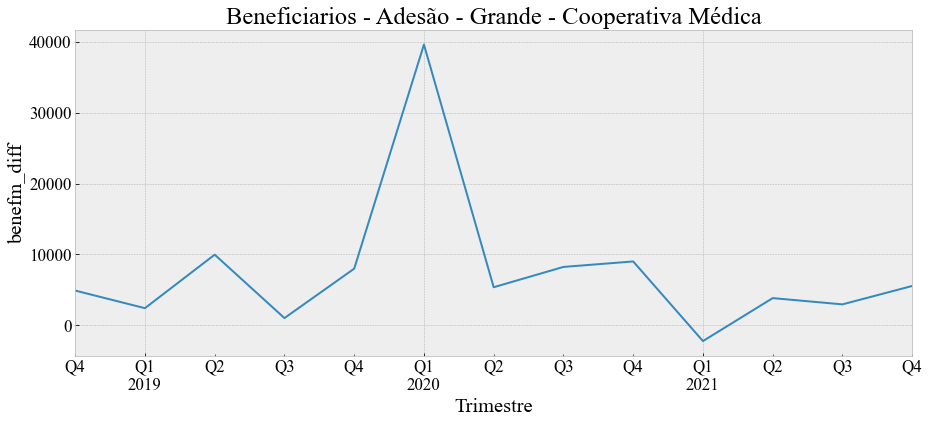

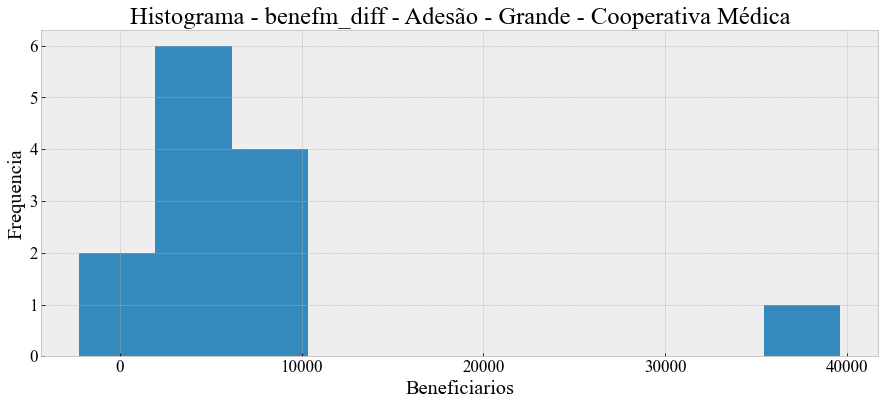

In [14]:
y_benefm.plot(y = 'Beneficiarios', figsize=(15,6))
plt.xlabel('Trimestre')
plt.ylabel(c)
plt.title(f'Beneficiarios - '+ grupo)
plt.show()

y_benefm.hist(bins='auto',figsize=(15,6))
plt.xlabel('Beneficiarios')
plt.ylabel('Frequencia')
plt.title(f'Histograma - {str(c)} - '+ grupo)
plt.show()

In [15]:
# Create Train test split
X_benefm_train, X_benefm_test, y_benefm_train, y_benefm_test = train_test_split(X_benefm,y_benefm, test_size=2, random_state=1234, shuffle=False)

#Normalização dos dados
scaler_X_benefm_train = preprocessing.MinMaxScaler(feature_range = (0,1))
scaler_X_benefm_train.fit(X_benefm_train)
X_benefm_train_scaled = scaler_X_benefm_train.transform(X_benefm_train)

y_benef_train_reshaped = y_benefm_train.to_numpy().reshape(-1,1)

scaler_y_benefm_train = preprocessing.MinMaxScaler(feature_range = (0,1))
scaler_y_benefm_train.fit(y_benef_train_reshaped)
y_benefm_train_scaled = scaler_y_benefm_train.transform(y_benef_train_reshaped)

In [16]:
#Inicio do treino
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
  
svm_regr_benefm = GridSearchCV(SVR(epsilon = 0.01), param_grid, refit = True, scoring='r2', verbose = 3)
  
# fitting the model for grid search
svm_regr_benefm.fit(X_benefm_train_scaled, y_benefm_train_scaled)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END .......C=0.1, gamma=1, kernel=rbf;, score=-0.680 total time=   0.0s
[CV 2/5] END .......C=0.1, gamma=1, kernel=rbf;, score=-0.313 total time=   0.0s
[CV 3/5] END .......C=0.1, gamma=1, kernel=rbf;, score=-1.014 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=1, kernel=rbf;, score=-81.984 total time=   0.0s
[CV 5/5] END .......C=0.1, gamma=1, kernel=rbf;, score=-4.389 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.1, kernel=rbf;, score=-0.324 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.028 total time=   0.0s
[CV 3/5] END .....C=0.1, gamma=0.1, kernel=rbf;, score=-1.136 total time=   0.0s
[CV 4/5] END ...C=0.1, gamma=0.1, kernel=rbf;, score=-118.372 total time=   0.0s
[CV 5/5] END .....C=0.1, gamma=0.1, kernel=rbf;, score=-5.143 total time=   0.0s
[CV 1/5] END ....C=0.1, gamma=0.01, kernel=rbf;, score=-0.124 total time=   0.0s
[CV 2/5] END ....C=0.1, gamma=0.01, kernel=rbf;

GridSearchCV(estimator=SVR(epsilon=0.01),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             scoring='r2', verbose=3)

In [17]:
X_benefm_test_scaled = scaler_X_benefm_train.transform(X_benefm_test)

y_benefm_pred_scaled = svm_regr_benefm.predict(X_benefm_test_scaled)
y_benefm_pred = scaler_y_benefm_train.inverse_transform(y_benefm_pred_scaled.reshape(-1,1))
y_benefm_pred = y_benefm_pred.reshape(-1)

#y_pred = rf_regr.predict(X_test)

best_params_benefm = svm_regr_benefm.best_params_

timeseries_evaluation_metrics_func(list(y_benefm_test),list(y_benefm_pred))
print('')
print('Hyper parameters')
print(svm_regr_benefm.best_params_)

Mean_Squared_Error_(MSE) is : 10788465.369280461
Root_Mean_Squared_Error_(RMSE) is : 3284.5799380256317
Mean_Absolute_Error_(MAE) is : 3209.855368467669
Mean_Absolute_Percentage_Error (MAPE) is : 0.7786840280456042
Symmetrical_Mean_Absolute_Percentage_Error (sMAPE) is : 0.5594418701092025
Coefficient of determination R^2 is : -5.390259751124055


Hyper parameters
{'C': 1, 'gamma': 1, 'kernel': 'rbf'}


In [18]:
df_benefm_pred = pd.DataFrame(y_benefm_pred, columns=['benefm'])
df_benefm_pred

,benefm
0,5459.891658
1,9451.819079


In [19]:
actual_df = pd.DataFrame(ans_agrup['benefm'].iloc[:-3])

display(actual_df)

res = inverse_diff(actual_df,df_benefm_pred)

res

,benefm
trimestre,
2019Q1,566867.333333
2019Q2,576833.333333
2019Q3,577843.000000
2019Q4,585833.666667
2020Q1,625470.000000
2020Q2,630837.666667
2020Q3,639071.666667
2020Q4,648078.666667
2021Q1,645841.333333


,benefm,benefm_1st_inv_diff
0,5459.891658,651301.224991
1,9451.819079,660753.044070


In [20]:
df_evaluation_metrics_benefm = timeseries_evaluation_metrics_func(list(ans_agrup['benefm'].iloc[-2:]),list(res['benefm_1st_inv_diff']))

df_evaluation_metrics_benefm.to_csv('svm_errors_metrics_benefm_grid_'+ grupo + '.csv',  sep=';', index=False, encoding='mbcs', decimal=',')

df_evaluation_metrics_benefm

Mean_Squared_Error_(MSE) is : 4220673.485672678
Root_Mean_Squared_Error_(RMSE) is : 2054.4277757255613
Mean_Absolute_Error_(MAE) is : 1953.2428729637177
Mean_Absolute_Percentage_Error (MAPE) is : 0.0029762168593412304
Symmetrical_Mean_Absolute_Percentage_Error (sMAPE) is : 0.002973371161881843
Coefficient of determination R^2 is : 0.450982189468773



,metrics,scores
0,MSE,4220673.485673
1,RMSE,2054.427776
2,MAE,1953.242873
3,MAPE,0.002976
4,sMAPE,0.002973
5,R^2,0.450982


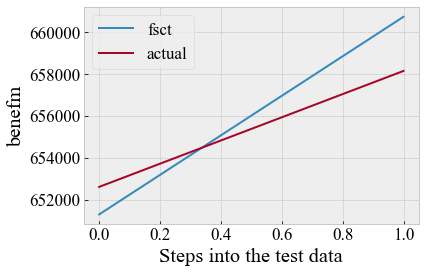

In [21]:
plt.plot(list(res['benefm_1st_inv_diff']))
plt.plot(list(ans_agrup['benefm'].iloc[-2:]))
plt.legend(['fsct','actual'])
plt.ylabel('benefm')
plt.xlabel('Steps into the test data')
plt.show()

In [22]:
#Retreinando random forest com os dados completos
#Normalização dos dados
scaler_X_benefm_train = preprocessing.MinMaxScaler(feature_range = (0,1))
scaler_X_benefm_train.fit(X_benefm)
X_benefm_scaled = scaler_X_benefm_train.transform(X_benefm)

y_benef_reshaped = y_benefm.to_numpy().reshape(-1,1)

scaler_y_benefm = preprocessing.MinMaxScaler(feature_range = (0,1))
scaler_y_benefm.fit(y_benef_reshaped)
y_benefm_scaled = scaler_y_benefm.transform(y_benef_reshaped)

In [23]:
svm_regr_benefm = SVR(  epsilon = 0.01,
                        C=best_params_benefm['C'],
                        gamma=best_params_benefm['gamma'],
                        kernel=best_params_benefm['kernel'])

# fitting the model for grid search
svm_regr_benefm.fit(X_benefm_scaled, y_benefm_scaled)

SVR(C=1, epsilon=0.01, gamma=1)

In [24]:
#dataframe teste para os 3 próximos anos

benefm_diff1_l1_list = [y_benefm.iloc[-1]]
benefm_diff1_l1_list_temp = [np.nan]*11
benefm_diff1_l1_list.extend(benefm_diff1_l1_list_temp)

benefm_diff2_l1_list = [ans_agrup_benefm['benefm_diff2'].iloc[-1]]
benefm_diff2_l1_list_temp = [np.nan]*11
benefm_diff2_l1_list.extend(benefm_diff2_l1_list_temp)

ipca_list = [0.032007, 0.02215]
ipca_list_temp = [0.03]*10
ipca_list.extend(ipca_list_temp)

selic_list = [0.000242, 0.000288]
selic_list_temp = [0.0002]*10
selic_list.extend(selic_list_temp)

dolar_list = np.array([ans_agrup_full['Dolar'].iloc[-1], 5.478567, 4.9849, 5.51, 5.65, 5.545, 5.85, 5.90, 6.05, 6.10, 6.15, 6.30, 6.40])
dolar_diff_list = np.diff(dolar_list)

pnad_list = [0.191, 0.140]
pnad_list_temp = [0.120]*10
pnad_list.extend(pnad_list_temp)

input = {'n_tri': [1,2,3,4, 1,2,3,4, 1,2,3,4],
         'n_tri_l1': [4, 1,2,3,4, 1,2,3,4,1,2,3],         
         'benefm_diff_l1':  benefm_diff1_l1_list,
         'benefm_diff2_l1': benefm_diff2_l1_list,         
         'IPCA': ipca_list,
         'Selic': selic_list,
         'Dolar_diff': dolar_diff_list,
         'PNAD_diff': pnad_list, 
         'dmy_covid': [1.0]*12,
         'dmy_n_ops': [0.0]*12}

index_df_pred_test = [  '2022Q1',
                        '2022Q2',
                        '2022Q3',
                        '2022Q4',
                        '2023Q1',
                        '2023Q2',
                        '2023Q3',
                        '2023Q4',
                        '2024Q1',
                        '2024Q2',
                        '2024Q3',
                        '2024Q4']

df_benef_pred_test = pd.DataFrame(input, index = index_df_pred_test)

df_benef_pred_test

,n_tri,n_tri_l1,benefm_diff_l1,benefm_diff2_l1,IPCA,Selic,Dolar_diff,PNAD_diff,dmy_covid,dmy_n_ops
2022Q1,1,4,5545.333333,2598.666667,0.032007,0.000242,0.102400,0.191000,1.000000,0.000000
2022Q2,2,1,NaN,NaN,0.022150,0.000288,-0.493667,0.140000,1.000000,0.000000
2022Q3,3,2,NaN,NaN,0.030000,0.000200,0.525100,0.120000,1.000000,0.000000
2022Q4,4,3,NaN,NaN,0.030000,0.000200,0.140000,0.120000,1.000000,0.000000
2023Q1,1,4,NaN,NaN,0.030000,0.000200,-0.105000,0.120000,1.000000,0.000000
2023Q2,2,1,NaN,NaN,0.030000,0.000200,0.305000,0.120000,1.000000,0.000000
2023Q3,3,2,NaN,NaN,0.030000,0.000200,0.050000,0.120000,1.000000,0.000000
2023Q4,4,3,NaN,NaN,0.030000,0.000200,0.150000,0.120000,1.000000,0.000000
2024Q1,1,4,NaN,NaN,0.030000,0.000200,0.050000,0.120000,1.000000,0.000000
2024Q2,2,1,NaN,NaN,0.030000,0.000200,0.050000,0.120000,1.000000,0.000000


In [25]:
#Treinar novamente o modelo com dados completos

In [26]:
y_pred_list = []

for i in range(len(df_benef_pred_test)):
    #X_test = df_pred_test.iloc[i:i+1]
    X_benefm_test = df_benef_pred_test.iloc[:i+1]
    X_benefm_test_scaled_pred = scaler_X_benefm_train.transform(X_benefm_test)

    y_benefm_pred_scaled = svm_regr_benefm.predict(X_benefm_test_scaled_pred)
    
    y_benefm_pred = scaler_y_benefm_train.inverse_transform(y_benefm_pred_scaled.reshape(-1,1))
    y_benefm_pred = y_benefm_pred.reshape(-1)

    #print(y_pred)
    #y_pred_list.append(y_pred)

    if i < len(df_benef_pred_test)-1:
        df_benef_pred_test['benefm_diff_l1'].iloc[i+1] = y_benefm_pred[-1]
        df_benef_pred_test['benefm_diff2_l1'].iloc[i+1] = y_benefm_pred[-1] - df_benef_pred_test['benefm_diff_l1'].iloc[i:i+1]

display(df_benef_pred_test)

y_benefm_pred

,n_tri,n_tri_l1,benefm_diff_l1,benefm_diff2_l1,IPCA,Selic,Dolar_diff,PNAD_diff,dmy_covid,dmy_n_ops
2022Q1,1,4,5545.333333,2598.666667,0.032007,0.000242,0.102400,0.191000,1.000000,0.000000
2022Q2,2,1,8355.926996,2810.593662,0.022150,0.000288,-0.493667,0.140000,1.000000,0.000000
2022Q3,3,2,11127.317265,2771.390269,0.030000,0.000200,0.525100,0.120000,1.000000,0.000000
2022Q4,4,3,6385.893857,-4741.423408,0.030000,0.000200,0.140000,0.120000,1.000000,0.000000
2023Q1,1,4,5300.590561,-1085.303296,0.030000,0.000200,-0.105000,0.120000,1.000000,0.000000
2023Q2,2,1,6127.443307,826.852746,0.030000,0.000200,0.305000,0.120000,1.000000,0.000000
2023Q3,3,2,9980.897340,3853.454032,0.030000,0.000200,0.050000,0.120000,1.000000,0.000000
2023Q4,4,3,5013.364859,-4967.532480,0.030000,0.000200,0.150000,0.120000,1.000000,0.000000
2024Q1,1,4,5409.372060,396.007200,0.030000,0.000200,0.050000,0.120000,1.000000,0.000000
2024Q2,2,1,6286.978412,877.606352,0.030000,0.000200,0.050000,0.120000,1.000000,0.000000


array([ 8355.92699557, 11127.31726472,  6385.8938567 ,  5300.59056112,
        6127.44330744,  9980.89733951,  5013.36485949,  5409.37205964,
        6286.97841153,  9576.31293502,  5253.37042496,  5266.72440722])

In [27]:
df_benefm_pred = pd.DataFrame(y_benefm_pred, columns=['benefm'], index = index_df_pred_test)
df_benefm_pred

,benefm
2022Q1,8355.926996
2022Q2,11127.317265
2022Q3,6385.893857
2022Q4,5300.590561
2023Q1,6127.443307
2023Q2,9980.897340
2023Q3,5013.364859
2023Q4,5409.372060
2024Q1,6286.978412
2024Q2,9576.312935


In [28]:
actual_df = pd.DataFrame(ans_agrup_benefm['benefm'])
#actual_df.set_index('trimestre', inplace=True)
pred_res = inverse_diff(actual_df,df_benefm_pred)
pred_res.rename({'benefm_1st_inv_diff': 'benefm_pred'}, axis=1, inplace=True)
pred_res['benefm_pred']

2022Q1   666518.926996
2022Q2   677646.244260
2022Q3   684032.138117
2022Q4   689332.728678
2023Q1   695460.171986
2023Q2   705441.069325
2023Q3   710454.434185
2023Q4   715863.806244
2024Q1   722150.784656
2024Q2   731727.097591
2024Q3   736980.468016
2024Q4   742247.192423
Name: benefm_pred, dtype: float64

In [29]:
ans_agrup_temp = pd.DataFrame(ans_agrup_full['benefm'])
ans_agrup_benefm_join = ans_agrup_temp.append(pd.DataFrame(pred_res['benefm_pred']))
ans_agrup_benefm_join

,benefm,benefm_pred
2018Q1,551754.666667,NaN
2018Q2,555789.666667,NaN
2018Q3,559564.000000,NaN
2018Q4,564459.666667,NaN
2019Q1,566867.333333,NaN
2019Q2,576833.333333,NaN
2019Q3,577843.000000,NaN
2019Q4,585833.666667,NaN
2020Q1,625470.000000,NaN
2020Q2,630837.666667,NaN


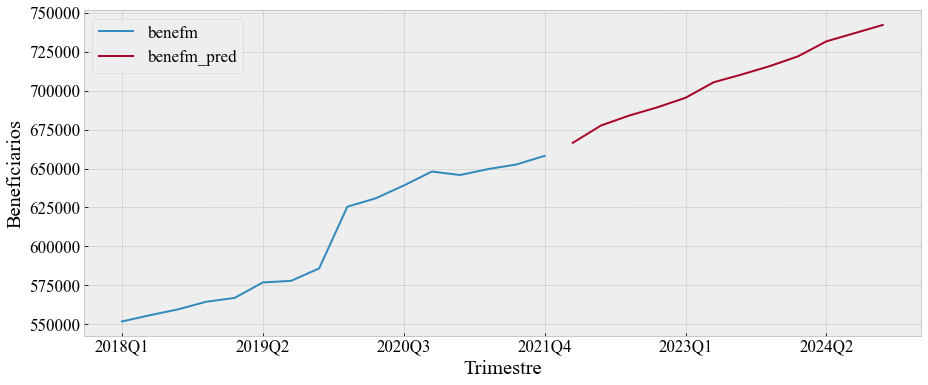

In [30]:
ans_agrup_benefm_join.plot(figsize=(15,6))
plt.legend(['benefm','benefm_pred'])
plt.ylabel('Beneficiarios')
plt.xlabel('Trimestre')
plt.show()

In [31]:
df_benefm_pred

,benefm
2022Q1,8355.926996
2022Q2,11127.317265
2022Q3,6385.893857
2022Q4,5300.590561
2023Q1,6127.443307
2023Q2,9980.897340
2023Q3,5013.364859
2023Q4,5409.372060
2024Q1,6286.978412
2024Q2,9576.312935


## Forecast da Receita - Random Forest

In [32]:
ans_agrup_rec = ans_agrup_full[['n_tri','n_tri_l1','receita','receita_diff','receita_diff2','receita_diff2_l1','receita_diff_l1','benefm_diff2_l1','benefm_diff','IPCA','Selic','Dolar','Dolar_diff','PNAD','PNAD_diff','dmy_covid','dmy_n_ops']]

ans_agrup_rec = ans_agrup_rec.dropna()

ans_agrup_rec

,n_tri,n_tri_l1,receita,receita_diff,receita_diff2,receita_diff2_l1,receita_diff_l1,benefm_diff2_l1,benefm_diff,IPCA,Selic,Dolar,Dolar_diff,PNAD,PNAD_diff,dmy_covid,dmy_n_ops
trimestre,,,,,,,,,,,,,,,,,
2018Q4,4.000000,3.000000,2.380000,0.090000,-0.040000,0.120000,0.130000,-260.666667,4895.666667,0.003894,0.000152,3.904500,0.050600,4424.000000,95.000000,1.000000,0.000000
2019Q1,1.000000,4.000000,2.370000,-0.010000,-0.100000,-0.040000,0.090000,1121.333333,2407.666667,0.015070,0.000150,3.776467,-0.128033,4419.000000,-5.000000,1.000000,0.000000
2019Q2,2.000000,1.000000,2.460000,0.090000,0.100000,-0.100000,-0.010000,-2488.000000,9966.000000,0.007108,0.000153,3.903500,0.127033,4327.000000,-92.000000,1.000000,0.000000
2019Q3,3.000000,2.000000,2.550000,0.090000,0.000000,0.100000,0.090000,7558.333333,1009.666667,0.002601,0.000153,3.882133,-0.021367,4286.000000,-41.000000,1.000000,0.000000
2019Q4,4.000000,3.000000,2.650000,0.100000,0.010000,0.000000,0.090000,-8956.333333,7990.666667,0.017675,0.000123,4.131167,0.249034,4410.000000,124.000000,1.000000,0.000000
2020Q1,1.000000,4.000000,2.750000,0.100000,0.000000,0.010000,0.100000,6981.000000,39636.333333,0.005308,0.000101,4.191133,0.059966,4355.000000,-55.000000,0.000000,1.000000
2020Q2,2.000000,1.000000,2.790000,0.040000,-0.060000,0.000000,0.100000,31645.666667,5367.666667,-0.004306,0.000073,5.272333,1.081200,4009.000000,-346.000000,0.000000,0.000000
2020Q3,3.000000,2.000000,2.830000,0.040000,0.000000,-0.060000,0.040000,-34268.666667,8234.000000,0.012447,0.000051,5.307533,0.035200,3837.000000,-172.000000,0.000000,0.000000
2020Q4,4.000000,3.000000,2.980000,0.150000,0.110000,0.000000,0.040000,2866.333333,9007.000000,0.031314,0.000047,5.458467,0.150934,3841.000000,4.000000,1.000000,0.000000


In [33]:
#Create X and y object
X_rec = ans_agrup_rec[['n_tri','n_tri_l1','receita_diff_l1','receita_diff2_l1','benefm_diff','IPCA','Selic','Dolar_diff','PNAD_diff','dmy_covid','dmy_n_ops']]
y_rec = ans_agrup_rec['receita_diff']

#Verificação da estacionariedade da receita
print('#########################################################################')
print('Teste Estacionaridade')
print('#########################################################################')
Augmented_Dickey_Fuller_Test_func(y_rec, 'receita_diff')

#########################################################################
Teste Estacionaridade
#########################################################################
Results of Dickey-Fuller Test for column receita_diff
Test Statistic                 -5.206978
p-value                         0.000009
No Lags Used                    3.000000
Number of Observartions Used    9.000000
Critical Value (1%)            -4.473135
Critical Value (5%)            -3.289881
Critical Value (10%)           -2.772382
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


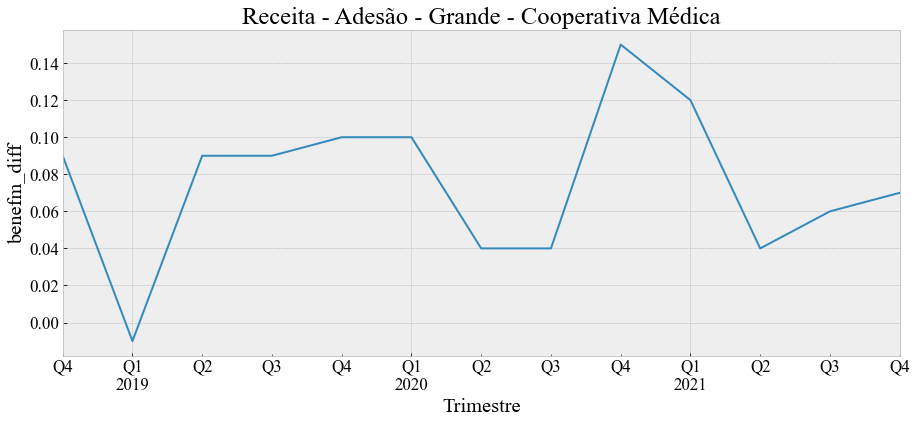

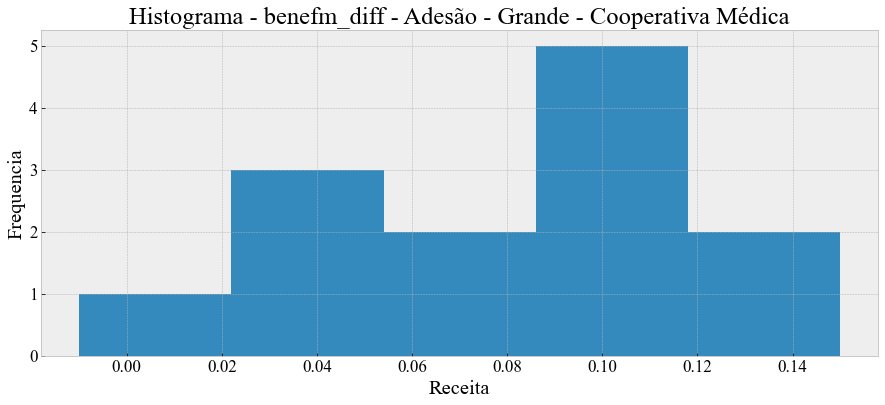

In [34]:
y_rec.plot(y = 'Receita', figsize=(15,6))
plt.xlabel('Trimestre')
plt.ylabel(c)
plt.title(f'Receita - '+ grupo)
plt.show()

y_rec.hist(bins='auto',figsize=(15,6))
plt.xlabel('Receita')
plt.ylabel('Frequencia')
plt.title(f'Histograma - {str(c)} - '+ grupo)
plt.show()

In [35]:
# Create Train test split
X_rec_train, X_rec_test, y_rec_train, y_rec_test = train_test_split(X_rec,y_rec, test_size=2, random_state=1234, shuffle=False)

#Normalização dos dados
scaler_X_rec_train = preprocessing.MinMaxScaler(feature_range = (0,1))
scaler_X_rec_train.fit(X_rec_train)
X_rec_train_scaled = scaler_X_rec_train.transform(X_rec_train)

y_rec_train_reshaped = y_rec_train.to_numpy().reshape(-1,1)

scaler_y_rec_train = preprocessing.MinMaxScaler(feature_range = (0,1))
scaler_y_rec_train.fit(y_rec_train_reshaped)
y_rec_train_scaled = scaler_y_rec_train.transform(y_rec_train_reshaped)

In [36]:
#Inicio do treino
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
  
svm_regr_rec_grid = GridSearchCV(SVR(epsilon = 0.01), param_grid, refit = True, scoring='r2', verbose = 3)
  
# fitting the model for grid search
svm_regr_rec_grid.fit(X_rec_train_scaled, y_rec_train_scaled)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END .......C=0.1, gamma=1, kernel=rbf;, score=-0.576 total time=   0.0s
[CV 2/5] END .......C=0.1, gamma=1, kernel=rbf;, score=-2.876 total time=   0.0s
[CV 3/5] END .......C=0.1, gamma=1, kernel=rbf;, score=-0.145 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.120 total time=   0.0s
[CV 5/5] END .......C=0.1, gamma=1, kernel=rbf;, score=-0.053 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.1, kernel=rbf;, score=-0.718 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.1, kernel=rbf;, score=-1.138 total time=   0.0s
[CV 3/5] END .....C=0.1, gamma=0.1, kernel=rbf;, score=-0.253 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.049 total time=   0.0s
[CV 5/5] END .....C=0.1, gamma=0.1, kernel=rbf;, score=-0.016 total time=   0.0s
[CV 1/5] END ....C=0.1, gamma=0.01, kernel=rbf;, score=-0.669 total time=   0.0s
[CV 2/5] END ....C=0.1, gamma=0.01, kernel=rbf;

GridSearchCV(estimator=SVR(epsilon=0.01),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             scoring='r2', verbose=3)

In [37]:
X_rec_test_scaled = scaler_X_rec_train.transform(X_rec_test)

y_rec_pred = svm_regr_rec_grid.predict(X_rec_test_scaled)
y_rec_pred = scaler_y_rec_train.inverse_transform(y_rec_pred.reshape(-1,1))
y_rec_pred = y_rec_pred.reshape(-1)

best_params_rec_grid = svm_regr_rec_grid.best_params_

timeseries_evaluation_metrics_func(list(y_rec_test),list(y_rec_pred))
print('')
print('Hyper parameters')
print(best_params_rec_grid)

Mean_Squared_Error_(MSE) is : 0.0013832031886515006
Root_Mean_Squared_Error_(RMSE) is : 0.03719143972275745
Mean_Absolute_Error_(MAE) is : 0.03686705505304576
Mean_Absolute_Percentage_Error (MAPE) is : 0.5763965320997124
Symmetrical_Mean_Absolute_Percentage_Error (sMAPE) is : 0.44408296393990926
Coefficient of determination R^2 is : -54.32812754606238


Hyper parameters
{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}


In [38]:
df_rec_pred = pd.DataFrame(y_rec_pred, columns=['receita'])
df_rec_pred

,receita
0,0.101768
1,0.101966


In [39]:
actual_df_rec = pd.DataFrame(ans_agrup['receita'].iloc[:-3])

display(actual_df_rec)

res_rec = inverse_diff(actual_df_rec,df_rec_pred)

res_rec

,receita
trimestre,
2019Q1,2.370000
2019Q2,2.460000
2019Q3,2.550000
2019Q4,2.650000
2020Q1,2.750000
2020Q2,2.790000
2020Q3,2.830000
2020Q4,2.980000
2021Q1,3.100000


,receita,receita_1st_inv_diff
0,0.101768,3.201768
1,0.101966,3.303734


In [40]:
df_evaluation_metrics_rec = timeseries_evaluation_metrics_func(list(ans_agrup['receita'].iloc[-2:]),list(res_rec['receita_1st_inv_diff']))

df_evaluation_metrics_rec.to_csv('svm_errors_metrics_rec_grid_'+ grupo +'.csv',  sep=';', index=False, encoding='mbcs', decimal=',')

df_evaluation_metrics_rec

Mean_Squared_Error_(MSE) is : 0.0005705587581623286
Root_Mean_Squared_Error_(RMSE) is : 0.023886371808257707
Mean_Absolute_Error_(MAE) is : 0.017751268216650296
Mean_Absolute_Percentage_Error (MAPE) is : 0.005434437424955397
Symmetrical_Mean_Absolute_Percentage_Error (sMAPE) is : 0.005407891418660653
Coefficient of determination R^2 is : 0.5342377484389134



,metrics,scores
0,MSE,0.000571
1,RMSE,0.023886
2,MAE,0.017751
3,MAPE,0.005434
4,sMAPE,0.005408
5,R^2,0.534238


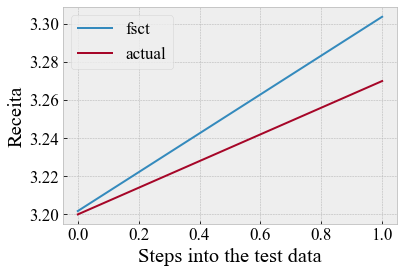

In [41]:
plt.plot(list(res_rec['receita_1st_inv_diff']))
plt.plot(list(ans_agrup['receita'].iloc[-2:]))
plt.legend(['fsct','actual'])
plt.ylabel('Receita')
plt.xlabel('Steps into the test data')
plt.show()

In [42]:
#Retreinando random forest com os dados completos
#Normalização dos dados
scaler_X_rec_train = preprocessing.MinMaxScaler(feature_range = (0,1))
scaler_X_rec_train.fit(X_rec)
X_rec_scaled = scaler_X_rec_train.transform(X_rec)

y_rec_reshaped = y_rec.to_numpy().reshape(-1,1)

scaler_y_rec = preprocessing.MinMaxScaler(feature_range = (0,1))
scaler_y_rec.fit(y_rec_reshaped)
y_rec_scaled = scaler_y_rec.transform(y_rec_reshaped)

In [43]:
svm_regr_rec = SVR( epsilon = 0.01,
                    C = best_params_benefm['C'],
                    gamma = best_params_benefm['gamma'],
                    kernel = best_params_benefm['kernel'])

# fitting the model for grid search
svm_regr_rec.fit(X_rec_scaled, y_rec_scaled)

SVR(C=1, epsilon=0.01, gamma=1)

In [44]:
#dataframe teste para os 3 próximos anos

receita_diff1_l1_list = [y_rec.iloc[-1]]
receita_diff1_l1_list_temp = [np.nan]*11
receita_diff1_l1_list.extend(receita_diff1_l1_list_temp)

receita_diff2_l1_list = [ans_agrup_rec['receita_diff2'].iloc[-1]]
receita_diff2_l1_list_temp = [np.nan]*11
receita_diff2_l1_list.extend(receita_diff2_l1_list_temp)

ipca_list = [0.032007, 0.02215]
ipca_list_temp = [0.03]*10
ipca_list.extend(ipca_list_temp)

selic_list = [0.000242, 0.000288]
selic_list_temp = [0.0002]*10
selic_list.extend(selic_list_temp)

#Lista de benefm diff estimados na etapa anterior desse código
benefm_diff_list = df_benefm_pred['benefm'].tolist()

dolar_list = np.array([ans_agrup_full['Dolar'].iloc[-1], 5.478567, 4.9849, 5.51, 5.65, 5.545, 5.85, 5.90, 6.05, 6.10, 6.15, 6.30, 6.40])
dolar_diff_list = np.diff(dolar_list)

pnad_list = [0.191, 0.140]
pnad_list_temp = [0.120]*10
pnad_list.extend(pnad_list_temp)


input = {'n_tri': [1,2,3,4, 1,2,3,4, 1,2,3,4],
         'n_tri_l1': [4, 1,2,3,4, 1,2,3,4,1,2,3],         
         'receita_diff_l1':  receita_diff1_l1_list,
         'receita_diff2_l1': receita_diff2_l1_list,
         'benefm_diff': benefm_diff_list,
         'IPCA': ipca_list,
         'Selic': selic_list,
         'Dolar_diff': dolar_diff_list,
         'PNAD_diff': pnad_list,
         'dmy_covid':[1.0]*12,
         'dmy_n_ops': [0.0]*12}

index_df_pred_test = [  '2022Q1',
                        '2022Q2',
                        '2022Q3',
                        '2022Q4',
                        '2023Q1',
                        '2023Q2',
                        '2023Q3',
                        '2023Q4',
                        '2024Q1',
                        '2024Q2',
                        '2024Q3',
                        '2024Q4']

df_rec_pred_test = pd.DataFrame(input, index = index_df_pred_test)

df_rec_pred_test

,n_tri,n_tri_l1,receita_diff_l1,receita_diff2_l1,benefm_diff,IPCA,Selic,Dolar_diff,PNAD_diff,dmy_covid,dmy_n_ops
2022Q1,1,4,0.070000,0.010000,8355.926996,0.032007,0.000242,0.102400,0.191000,1.000000,0.000000
2022Q2,2,1,NaN,NaN,11127.317265,0.022150,0.000288,-0.493667,0.140000,1.000000,0.000000
2022Q3,3,2,NaN,NaN,6385.893857,0.030000,0.000200,0.525100,0.120000,1.000000,0.000000
2022Q4,4,3,NaN,NaN,5300.590561,0.030000,0.000200,0.140000,0.120000,1.000000,0.000000
2023Q1,1,4,NaN,NaN,6127.443307,0.030000,0.000200,-0.105000,0.120000,1.000000,0.000000
2023Q2,2,1,NaN,NaN,9980.897340,0.030000,0.000200,0.305000,0.120000,1.000000,0.000000
2023Q3,3,2,NaN,NaN,5013.364859,0.030000,0.000200,0.050000,0.120000,1.000000,0.000000
2023Q4,4,3,NaN,NaN,5409.372060,0.030000,0.000200,0.150000,0.120000,1.000000,0.000000
2024Q1,1,4,NaN,NaN,6286.978412,0.030000,0.000200,0.050000,0.120000,1.000000,0.000000
2024Q2,2,1,NaN,NaN,9576.312935,0.030000,0.000200,0.050000,0.120000,1.000000,0.000000


In [45]:
#y_pred_list = []

for i in range(len(df_rec_pred_test)):
    #X_test = df_pred_test.iloc[i:i+1]
    X_rec_test = df_rec_pred_test.iloc[:i+1]
    X_rec_test_scaled_test = scaler_X_rec_train.transform(X_rec_test)
    
    y_rec_pred = svm_regr_rec.predict(X_rec_test_scaled_test)
    y_rec_pred = scaler_y_rec_train.inverse_transform(y_rec_pred.reshape(-1,1))
    y_rec_pred = y_rec_pred.reshape(-1)

    #print(y_pred)
    #y_pred_list.append(y_pred)

    if i < len(df_rec_pred_test)-1:
        df_rec_pred_test['receita_diff_l1'].iloc[i+1] = y_rec_pred[-1]
        df_rec_pred_test['receita_diff2_l1'].iloc[i+1] = y_rec_pred[-1] - df_rec_pred_test['receita_diff_l1'].iloc[i:i+1]

display(df_rec_pred_test)

y_rec_pred

,n_tri,n_tri_l1,receita_diff_l1,receita_diff2_l1,benefm_diff,IPCA,Selic,Dolar_diff,PNAD_diff,dmy_covid,dmy_n_ops
2022Q1,1,4,0.070000,0.010000,8355.926996,0.032007,0.000242,0.102400,0.191000,1.000000,0.000000
2022Q2,2,1,0.030459,-0.039541,11127.317265,0.022150,0.000288,-0.493667,0.140000,1.000000,0.000000
2022Q3,3,2,0.072340,0.041880,6385.893857,0.030000,0.000200,0.525100,0.120000,1.000000,0.000000
2022Q4,4,3,0.063896,-0.008444,5300.590561,0.030000,0.000200,0.140000,0.120000,1.000000,0.000000
2023Q1,1,4,0.064530,0.000634,6127.443307,0.030000,0.000200,-0.105000,0.120000,1.000000,0.000000
2023Q2,2,1,0.012498,-0.052032,9980.897340,0.030000,0.000200,0.305000,0.120000,1.000000,0.000000
2023Q3,3,2,0.067820,0.055323,5013.364859,0.030000,0.000200,0.050000,0.120000,1.000000,0.000000
2023Q4,4,3,0.061884,-0.005936,5409.372060,0.030000,0.000200,0.150000,0.120000,1.000000,0.000000
2024Q1,1,4,0.065030,0.003146,6286.978412,0.030000,0.000200,0.050000,0.120000,1.000000,0.000000
2024Q2,2,1,0.014179,-0.050851,9576.312935,0.030000,0.000200,0.050000,0.120000,1.000000,0.000000


array([0.03045943, 0.07233979, 0.06389581, 0.06452978, 0.01249783,
       0.06782037, 0.06188435, 0.06503017, 0.01417927, 0.0650782 ,
       0.0621706 , 0.06479373])

In [46]:
df_rec_pred = pd.DataFrame(y_rec_pred, columns=['receita'], index = index_df_pred_test)
df_rec_pred

,receita
2022Q1,0.030459
2022Q2,0.072340
2022Q3,0.063896
2022Q4,0.064530
2023Q1,0.012498
2023Q2,0.067820
2023Q3,0.061884
2023Q4,0.065030
2024Q1,0.014179
2024Q2,0.065078


In [47]:
actual_df_rec = pd.DataFrame(ans_agrup_rec['receita'])

pred_res_rec = inverse_diff(actual_df_rec,df_rec_pred)
pred_res_rec.rename({'receita_1st_inv_diff': 'receita_pred'}, axis=1, inplace=True)
pred_res_rec['receita_pred']

2022Q1   3.300459
2022Q2   3.372799
2022Q3   3.436695
2022Q4   3.501225
2023Q1   3.513723
2023Q2   3.581543
2023Q3   3.643427
2023Q4   3.708458
2024Q1   3.722637
2024Q2   3.787715
2024Q3   3.849886
2024Q4   3.914679
Name: receita_pred, dtype: float64

In [48]:
ans_agrup_temp = pd.DataFrame(ans_agrup_full['receita'])
ans_agrup_rec_join = ans_agrup_temp.append(pd.DataFrame(pred_res_rec['receita_pred']))
ans_agrup_rec_join

,receita,receita_pred
2018Q1,2.150000,NaN
2018Q2,2.160000,NaN
2018Q3,2.290000,NaN
2018Q4,2.380000,NaN
2019Q1,2.370000,NaN
2019Q2,2.460000,NaN
2019Q3,2.550000,NaN
2019Q4,2.650000,NaN
2020Q1,2.750000,NaN
2020Q2,2.790000,NaN


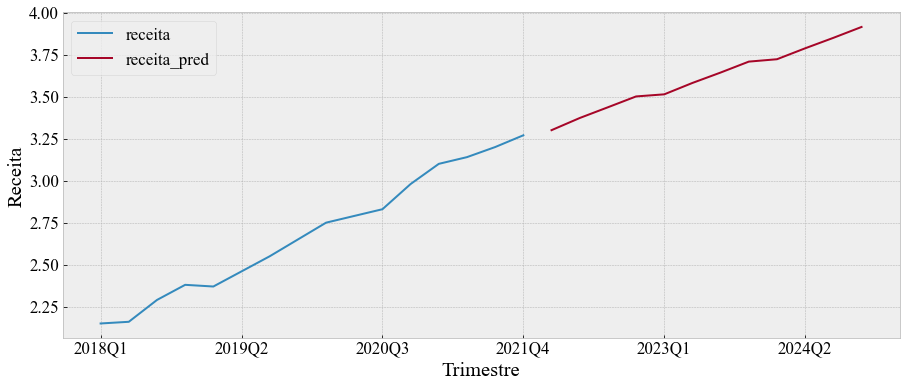

In [49]:
ans_agrup_rec_join.plot(figsize=(15,6))
plt.legend(['receita','receita_pred'])
plt.ylabel('Receita')
plt.xlabel('Trimestre')
plt.show()

## Forecast Despesa

In [50]:
ans_agrup_desp = ans_agrup_full[['n_tri','n_tri_l1','despesa','despesa_diff','despesa_diff2','despesa_diff2_l1','despesa_diff_l1','despesa_diff2_l1','benefm_diff','IPCA','Selic','Dolar','Dolar_diff','PNAD','PNAD_diff','dmy_covid','dmy_n_ops']]

ans_agrup_desp = ans_agrup_desp.dropna()

ans_agrup_desp

,n_tri,n_tri_l1,despesa,despesa_diff,despesa_diff2,despesa_diff2_l1,despesa_diff_l1,despesa_diff2_l1,benefm_diff,IPCA,Selic,Dolar,Dolar_diff,PNAD,PNAD_diff,dmy_covid,dmy_n_ops
trimestre,,,,,,,,,,,,,,,,,
2018Q4,4.000000,3.000000,1.250000,-0.600000,-0.810000,0.150000,0.210000,0.150000,4895.666667,0.003894,0.000152,3.904500,0.050600,4424.000000,95.000000,1.000000,0.000000
2019Q1,1.000000,4.000000,1.870000,0.620000,1.220000,-0.810000,-0.600000,-0.810000,2407.666667,0.015070,0.000150,3.776467,-0.128033,4419.000000,-5.000000,1.000000,0.000000
2019Q2,2.000000,1.000000,1.980000,0.110000,-0.510000,1.220000,0.620000,1.220000,9966.000000,0.007108,0.000153,3.903500,0.127033,4327.000000,-92.000000,1.000000,0.000000
2019Q3,3.000000,2.000000,1.950000,-0.030000,-0.140000,-0.510000,0.110000,-0.510000,1009.666667,0.002601,0.000153,3.882133,-0.021367,4286.000000,-41.000000,1.000000,0.000000
2019Q4,4.000000,3.000000,2.080000,0.130000,0.160000,-0.140000,-0.030000,-0.140000,7990.666667,0.017675,0.000123,4.131167,0.249034,4410.000000,124.000000,1.000000,0.000000
2020Q1,1.000000,4.000000,2.100000,0.020000,-0.110000,0.160000,0.130000,0.160000,39636.333333,0.005308,0.000101,4.191133,0.059966,4355.000000,-55.000000,0.000000,1.000000
2020Q2,2.000000,1.000000,1.750000,-0.350000,-0.370000,-0.110000,0.020000,-0.110000,5367.666667,-0.004306,0.000073,5.272333,1.081200,4009.000000,-346.000000,0.000000,0.000000
2020Q3,3.000000,2.000000,2.150000,0.400000,0.750000,-0.370000,-0.350000,-0.370000,8234.000000,0.012447,0.000051,5.307533,0.035200,3837.000000,-172.000000,0.000000,0.000000
2020Q4,4.000000,3.000000,2.460000,0.310000,-0.090000,0.750000,0.400000,0.750000,9007.000000,0.031314,0.000047,5.458467,0.150934,3841.000000,4.000000,1.000000,0.000000


In [51]:
#Create X and y object
X_desp = ans_agrup_desp[['n_tri','n_tri_l1','despesa_diff_l1','despesa_diff2_l1','benefm_diff','IPCA','Selic','Dolar_diff','PNAD_diff','dmy_covid','dmy_n_ops']]
y_desp = ans_agrup_desp['despesa_diff']

#Verificação da estacionariedade do número beneficiarios
print('########################################################')
print('Teste Estacionaridade')
print('########################################################')
Augmented_Dickey_Fuller_Test_func(y_desp, 'despesa_diff')

########################################################
Teste Estacionaridade
########################################################
Results of Dickey-Fuller Test for column despesa_diff
Test Statistic                 -2.139302
p-value                         0.229007
No Lags Used                    4.000000
Number of Observartions Used    8.000000
Critical Value (1%)            -4.665186
Critical Value (5%)            -3.367187
Critical Value (10%)           -2.802961
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


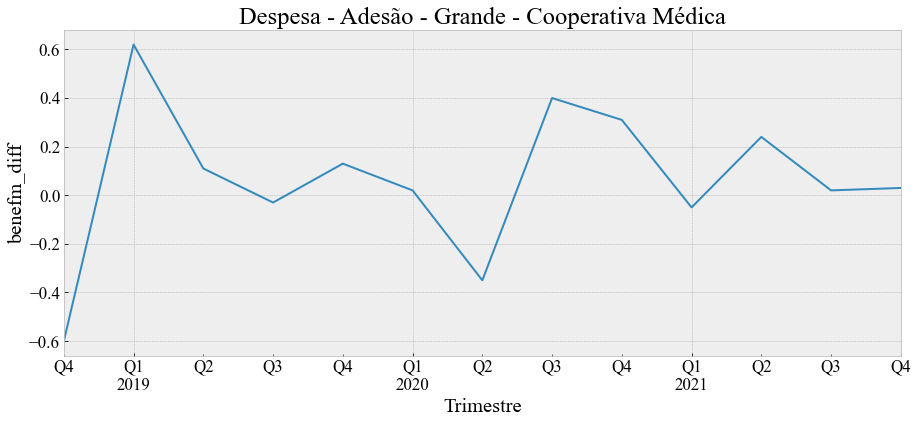

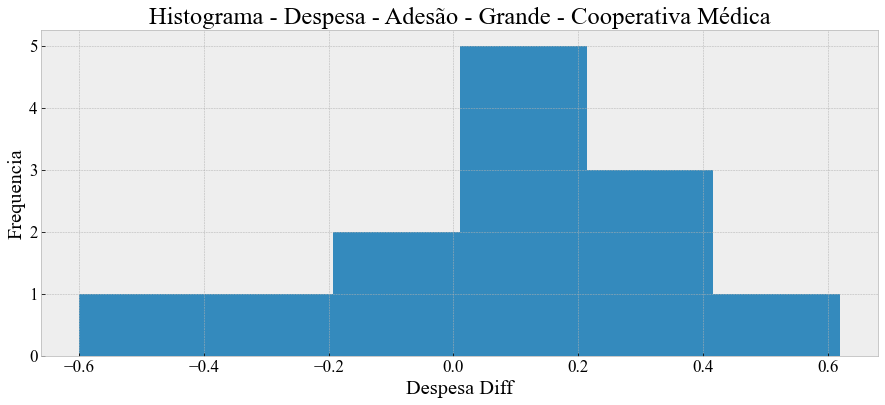

In [52]:
y_desp.plot(y = 'Despesa', figsize=(15,6))
plt.xlabel('Trimestre')
plt.ylabel(c)
plt.title(f'Despesa - '+ grupo)
plt.show()

y_desp.hist(bins='auto',figsize=(15,6))
plt.xlabel('Despesa Diff')
plt.ylabel('Frequencia')
plt.title(f'Histograma - '+'Despesa - ' + grupo)
plt.show()

In [53]:
# Create Train test split
X_desp_train, X_desp_test, y_desp_train, y_desp_test = train_test_split(X_desp,y_desp, test_size=2, random_state=1234, shuffle=False)

#Normalização dos dados
scaler_X_desp_train = preprocessing.MinMaxScaler(feature_range = (0,1))
scaler_X_desp_train.fit(X_desp_train)
X_desp_train_scaled = scaler_X_desp_train.transform(X_desp_train)

y_desp_train_reshaped = y_desp_train.to_numpy().reshape(-1,1)

scaler_y_desp_train = preprocessing.MinMaxScaler(feature_range = (0,1))
scaler_y_desp_train.fit(y_desp_train_reshaped)
y_desp_train_scaled = scaler_y_desp_train.transform(y_desp_train_reshaped)

In [54]:
#Inicio do treino
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
  
svm_regr_desp_grid = GridSearchCV(SVR(epsilon = 0.01), param_grid, refit = True, scoring='r2', verbose = 3)
  
# fitting the model for grid search
svm_regr_desp_grid.fit(X_desp_train_scaled, y_desp_train_scaled)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END .......C=0.1, gamma=1, kernel=rbf;, score=-0.018 total time=   0.0s
[CV 2/5] END .......C=0.1, gamma=1, kernel=rbf;, score=-0.902 total time=   0.0s
[CV 3/5] END .......C=0.1, gamma=1, kernel=rbf;, score=-4.492 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=1, kernel=rbf;, score=-52.926 total time=   0.0s
[CV 5/5] END .......C=0.1, gamma=1, kernel=rbf;, score=-0.310 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.1, kernel=rbf;, score=-0.058 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.1, kernel=rbf;, score=-1.067 total time=   0.0s
[CV 3/5] END .....C=0.1, gamma=0.1, kernel=rbf;, score=-3.566 total time=   0.0s
[CV 4/5] END ....C=0.1, gamma=0.1, kernel=rbf;, score=-55.000 total time=   0.0s
[CV 5/5] END .....C=0.1, gamma=0.1, kernel=rbf;, score=-0.160 total time=   0.0s
[CV 1/5] END ....C=0.1, gamma=0.01, kernel=rbf;, score=-0.011 total time=   0.0s
[CV 2/5] END ....C=0.1, gamma=0.01, kernel=rbf;

GridSearchCV(estimator=SVR(epsilon=0.01),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             scoring='r2', verbose=3)

In [55]:
X_desp_test_scaled = scaler_X_desp_train.transform(X_desp_test)

y_desp_pred = svm_regr_desp_grid.predict(X_desp_test_scaled)
y_desp_pred = scaler_y_desp_train.inverse_transform(y_desp_pred.reshape(-1,1))
y_desp_pred = y_desp_pred.reshape(-1)

best_params_desp_bayes = svm_regr_desp_grid.best_params_

timeseries_evaluation_metrics_func(list(y_desp_test),list(y_desp_pred))
print('')
print('Hyper parameters')
print(best_params_desp_bayes)

Mean_Squared_Error_(MSE) is : 0.006886473328345447
Root_Mean_Squared_Error_(RMSE) is : 0.08298477769052254
Mean_Absolute_Error_(MAE) is : 0.08283404112029454
Mean_Absolute_Percentage_Error (MAPE) is : 3.493080846489561
Symmetrical_Mean_Absolute_Percentage_Error (sMAPE) is : 1.2517885509381466
Coefficient of determination R^2 is : -274.45893313380515


Hyper parameters
{'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}


In [56]:
df_desp_pred = pd.DataFrame(y_desp_pred, columns=['despesa'])
df_desp_pred

,despesa
0,0.107834
1,0.107835


In [57]:
actual_desp_df = pd.DataFrame(ans_agrup_desp['despesa'].iloc[:-2])

display(actual_desp_df)

res_desp = inverse_diff(actual_desp_df,df_desp_pred)

res_desp

,despesa
trimestre,
2018Q4,1.250000
2019Q1,1.870000
2019Q2,1.980000
2019Q3,1.950000
2019Q4,2.080000
2020Q1,2.100000
2020Q2,1.750000
2020Q3,2.150000
2020Q4,2.460000


,despesa,despesa_1st_inv_diff
0,0.107834,2.757834
1,0.107835,2.865668


In [58]:
df_evaluation_metrics_desp = timeseries_evaluation_metrics_func(list(ans_agrup['despesa'].iloc[-2:]),list(res_desp['despesa_1st_inv_diff']))

df_evaluation_metrics_desp.to_csv('svm_errors_metrics_desp_grid_'+ grupo +'.csv',  sep=';', index=False, encoding='mbcs', decimal=',')

df_evaluation_metrics_desp

Mean_Squared_Error_(MSE) is : 0.01758032185617247
Root_Mean_Squared_Error_(RMSE) is : 0.13259080607708992
Mean_Absolute_Error_(MAE) is : 0.12675080966907992
Mean_Absolute_Percentage_Error (MAPE) is : 0.04712750240989138
Symmetrical_Mean_Absolute_Percentage_Error (sMAPE) is : 0.04594813464813009
Coefficient of determination R^2 is : -77.13476380520967



,metrics,scores
0,MSE,0.017580
1,RMSE,0.132591
2,MAE,0.126751
3,MAPE,0.047128
4,sMAPE,0.045948
5,R^2,-77.134764


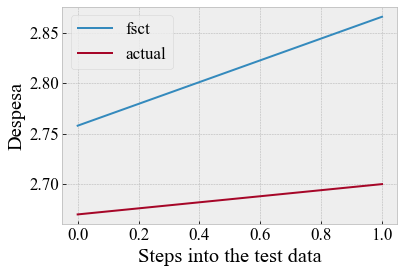

In [59]:
plt.plot(list(res_desp['despesa_1st_inv_diff']))
plt.plot(list(ans_agrup['despesa'].iloc[-2:]))
plt.legend(['fsct','actual'])
plt.ylabel('Despesa')
plt.xlabel('Steps into the test data')
plt.show()

In [60]:
#Retreinando random forest com os dados completos
#Normalização dos dados
scaler_X_desp_train = preprocessing.MinMaxScaler(feature_range = (0,1))
scaler_X_desp_train.fit(X_desp)
X_desp_scaled = scaler_X_desp_train.transform(X_desp)

y_desp_reshaped = y_desp.to_numpy().reshape(-1,1)

scaler_y_desp = preprocessing.MinMaxScaler(feature_range = (0,1))
scaler_y_desp.fit(y_desp_reshaped)
y_desp_scaled = scaler_y_desp.transform(y_desp_reshaped)

In [61]:
svm_regr_desp = SVR( epsilon = 0.01,
                    C = best_params_benefm['C'],
                    gamma = best_params_benefm['gamma'],
                    kernel = best_params_benefm['kernel'])

# fitting the model for grid search
svm_regr_desp.fit(X_desp_scaled, y_desp_scaled)

SVR(C=1, epsilon=0.01, gamma=1)

In [62]:
#dataframe teste para os 3 próximos anos

despesa_diff1_l1_list = [y_desp.iloc[-1]]
despesa_diff1_l1_list_temp = [np.nan]*11
despesa_diff1_l1_list.extend(despesa_diff1_l1_list_temp)

despesa_diff2_l1_list = [y_desp.iloc[-2]]
despesa_diff2_l1_list_temp = [np.nan]*11
despesa_diff2_l1_list.extend(despesa_diff2_l1_list_temp)

ipca_list = [0.032007, 0.02215]
ipca_list_temp = [0.03]*10
ipca_list.extend(ipca_list_temp)

selic_list = [0.000242, 0.000288]
selic_list_temp = [0.0002]*10
selic_list.extend(selic_list_temp)

benefm_diff_list = df_benefm_pred['benefm'].tolist()

dolar_list = np.array([ans_agrup_full['Dolar'].iloc[-1], 5.478567, 4.9849, 5.51, 5.65, 5.545, 5.85, 5.90, 6.05, 6.10, 6.15, 6.30, 6.40])
dolar_diff_list = np.diff(dolar_list)

pnad_list = [0.191, 0.140]
pnad_list_temp = [0.120]*10
pnad_list.extend(pnad_list_temp)

input = {'n_tri': [1,2,3,4, 1,2,3,4, 1,2,3,4],
         'n_tri_l1': [4, 1,2,3,4, 1,2,3,4,1,2,3],
         'n_ops': [39.0]*12,
         'despesa_diff_l1':  despesa_diff1_l1_list,
         'despesa_diff_l2': despesa_diff2_l1_list,
         'benefm_diff': benefm_diff_list,
         'IPCA': ipca_list,
         'Selic': selic_list,
         'Dolar_diff': dolar_diff_list,
         'PNAD_diff': pnad_list,
         'dmy_covid':[1.0]*12,
         'dmy_n_ops': [0.0]*12}

index_df_pred_test = [  '2022Q1',
                        '2022Q2',
                        '2022Q3',
                        '2022Q4',
                        '2023Q1',
                        '2023Q2',
                        '2023Q3',
                        '2023Q4',
                        '2024Q1',
                        '2024Q2',
                        '2024Q3',
                        '2024Q4']

df_desp_pred_test = pd.DataFrame(input, index = index_df_pred_test)

df_desp_pred_test

,n_tri,n_tri_l1,n_ops,despesa_diff_l1,despesa_diff_l2,benefm_diff,IPCA,Selic,Dolar_diff,PNAD_diff,dmy_covid,dmy_n_ops
2022Q1,1,4,39.000000,0.030000,0.020000,8355.926996,0.032007,0.000242,0.102400,0.191000,1.000000,0.000000
2022Q2,2,1,39.000000,NaN,NaN,11127.317265,0.022150,0.000288,-0.493667,0.140000,1.000000,0.000000
2022Q3,3,2,39.000000,NaN,NaN,6385.893857,0.030000,0.000200,0.525100,0.120000,1.000000,0.000000
2022Q4,4,3,39.000000,NaN,NaN,5300.590561,0.030000,0.000200,0.140000,0.120000,1.000000,0.000000
2023Q1,1,4,39.000000,NaN,NaN,6127.443307,0.030000,0.000200,-0.105000,0.120000,1.000000,0.000000
2023Q2,2,1,39.000000,NaN,NaN,9980.897340,0.030000,0.000200,0.305000,0.120000,1.000000,0.000000
2023Q3,3,2,39.000000,NaN,NaN,5013.364859,0.030000,0.000200,0.050000,0.120000,1.000000,0.000000
2023Q4,4,3,39.000000,NaN,NaN,5409.372060,0.030000,0.000200,0.150000,0.120000,1.000000,0.000000
2024Q1,1,4,39.000000,NaN,NaN,6286.978412,0.030000,0.000200,0.050000,0.120000,1.000000,0.000000
2024Q2,2,1,39.000000,NaN,NaN,9576.312935,0.030000,0.000200,0.050000,0.120000,1.000000,0.000000


In [63]:
for i in range(len(df_desp_pred_test)):
    #X_test = df_pred_test.iloc[i:i+1]
    X_desp_test = df_desp_pred_test.iloc[:i+1]
    X_desp_test_scaled_test = scaler_X_desp_train.transform(X_desp_test)

    y_desp_pred = svm_regr_desp.predict(X_desp_test_scaled_test)
    y_desp_pred = scaler_y_desp_train.inverse_transform(y_desp_pred.reshape(-1,1))
    y_desp_pred = y_desp_pred.reshape(-1)


    if i < len(df_desp_pred_test)-1:
        df_desp_pred_test['despesa_diff_l1'].iloc[i+1] = y_desp_pred[-1]
        df_desp_pred_test['despesa_diff_l2'].iloc[i+1] = y_rec_pred[-1] - df_desp_pred_test['despesa_diff_l1'].iloc[i:i+1]

display(df_desp_pred_test)

y_desp_pred

,n_tri,n_tri_l1,n_ops,despesa_diff_l1,despesa_diff_l2,benefm_diff,IPCA,Selic,Dolar_diff,PNAD_diff,dmy_covid,dmy_n_ops
2022Q1,1,4,39.000000,0.030000,0.020000,8355.926996,0.032007,0.000242,0.102400,0.191000,1.000000,0.000000
2022Q2,2,1,39.000000,0.079686,0.034794,11127.317265,0.022150,0.000288,-0.493667,0.140000,1.000000,0.000000
2022Q3,3,2,39.000000,0.079686,-0.014892,6385.893857,0.030000,0.000200,0.525100,0.120000,1.000000,0.000000
2022Q4,4,3,39.000000,0.079686,-0.014892,5300.590561,0.030000,0.000200,0.140000,0.120000,1.000000,0.000000
2023Q1,1,4,39.000000,0.079686,-0.014892,6127.443307,0.030000,0.000200,-0.105000,0.120000,1.000000,0.000000
2023Q2,2,1,39.000000,0.079686,-0.014892,9980.897340,0.030000,0.000200,0.305000,0.120000,1.000000,0.000000
2023Q3,3,2,39.000000,0.079686,-0.014892,5013.364859,0.030000,0.000200,0.050000,0.120000,1.000000,0.000000
2023Q4,4,3,39.000000,0.079686,-0.014892,5409.372060,0.030000,0.000200,0.150000,0.120000,1.000000,0.000000
2024Q1,1,4,39.000000,0.079686,-0.014892,6286.978412,0.030000,0.000200,0.050000,0.120000,1.000000,0.000000
2024Q2,2,1,39.000000,0.079686,-0.014892,9576.312935,0.030000,0.000200,0.050000,0.120000,1.000000,0.000000


array([0.07968568, 0.07968568, 0.07968568, 0.07968568, 0.07968568,
       0.07968568, 0.07968568, 0.07968568, 0.07968568, 0.07968568,
       0.07968568, 0.07968568])

In [64]:
df_desp_pred = pd.DataFrame(y_desp_pred, columns=['despesa'], index = index_df_pred_test)
df_desp_pred

,despesa
2022Q1,0.079686
2022Q2,0.079686
2022Q3,0.079686
2022Q4,0.079686
2023Q1,0.079686
2023Q2,0.079686
2023Q3,0.079686
2023Q4,0.079686
2024Q1,0.079686
2024Q2,0.079686


In [65]:
actual_desp_df = pd.DataFrame(ans_agrup_desp['despesa'])
#actual_df.set_index('trimestre', inplace=True)
pred_res_desp = inverse_diff(actual_desp_df,df_desp_pred)
pred_res_desp.rename({'despesa_1st_inv_diff': 'despesa_pred'}, axis=1, inplace=True)
pred_res_desp['despesa_pred']

2022Q1   2.779686
2022Q2   2.859371
2022Q3   2.939057
2022Q4   3.018743
2023Q1   3.098428
2023Q2   3.178114
2023Q3   3.257800
2023Q4   3.337485
2024Q1   3.417171
2024Q2   3.496857
2024Q3   3.576542
2024Q4   3.656228
Name: despesa_pred, dtype: float64

In [66]:
ans_agrup_temp = pd.DataFrame(ans_agrup_full['despesa'])
ans_agrup_desp_join = ans_agrup_temp.append(pd.DataFrame(pred_res_desp['despesa_pred']))
ans_agrup_desp_join

,despesa,despesa_pred
2018Q1,1.580000,NaN
2018Q2,1.640000,NaN
2018Q3,1.850000,NaN
2018Q4,1.250000,NaN
2019Q1,1.870000,NaN
2019Q2,1.980000,NaN
2019Q3,1.950000,NaN
2019Q4,2.080000,NaN
2020Q1,2.100000,NaN
2020Q2,1.750000,NaN


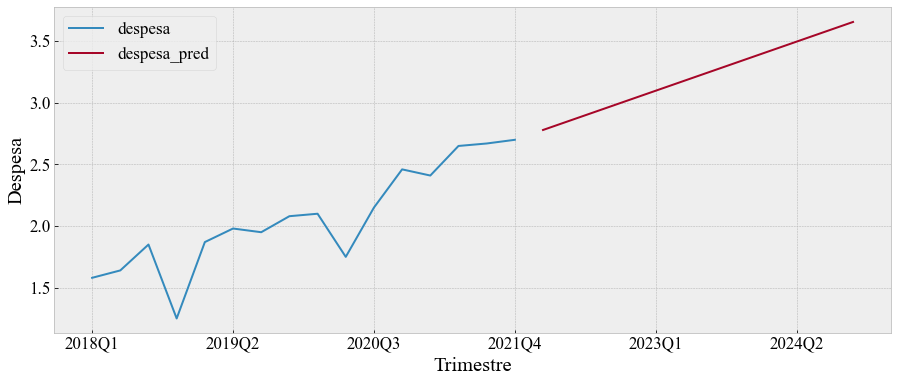

In [67]:
ans_agrup_desp_join.plot(figsize=(15,6))
plt.legend(['despesa','despesa_pred'])
plt.ylabel('Despesa')
plt.xlabel('Trimestre')
plt.show()

In [68]:
ans_agrup_pred_temp = ans_agrup_rec_join.join(ans_agrup_desp_join)

ans_agrup_pred = ans_agrup_pred_temp.join(ans_agrup_benefm_join)

ans_agrup_pred

,receita,receita_pred,despesa,despesa_pred,benefm,benefm_pred
2018Q1,2.150000,NaN,1.580000,NaN,551754.666667,NaN
2018Q2,2.160000,NaN,1.640000,NaN,555789.666667,NaN
2018Q3,2.290000,NaN,1.850000,NaN,559564.000000,NaN
2018Q4,2.380000,NaN,1.250000,NaN,564459.666667,NaN
2019Q1,2.370000,NaN,1.870000,NaN,566867.333333,NaN
2019Q2,2.460000,NaN,1.980000,NaN,576833.333333,NaN
2019Q3,2.550000,NaN,1.950000,NaN,577843.000000,NaN
2019Q4,2.650000,NaN,2.080000,NaN,585833.666667,NaN
2020Q1,2.750000,NaN,2.100000,NaN,625470.000000,NaN
2020Q2,2.790000,NaN,1.750000,NaN,630837.666667,NaN


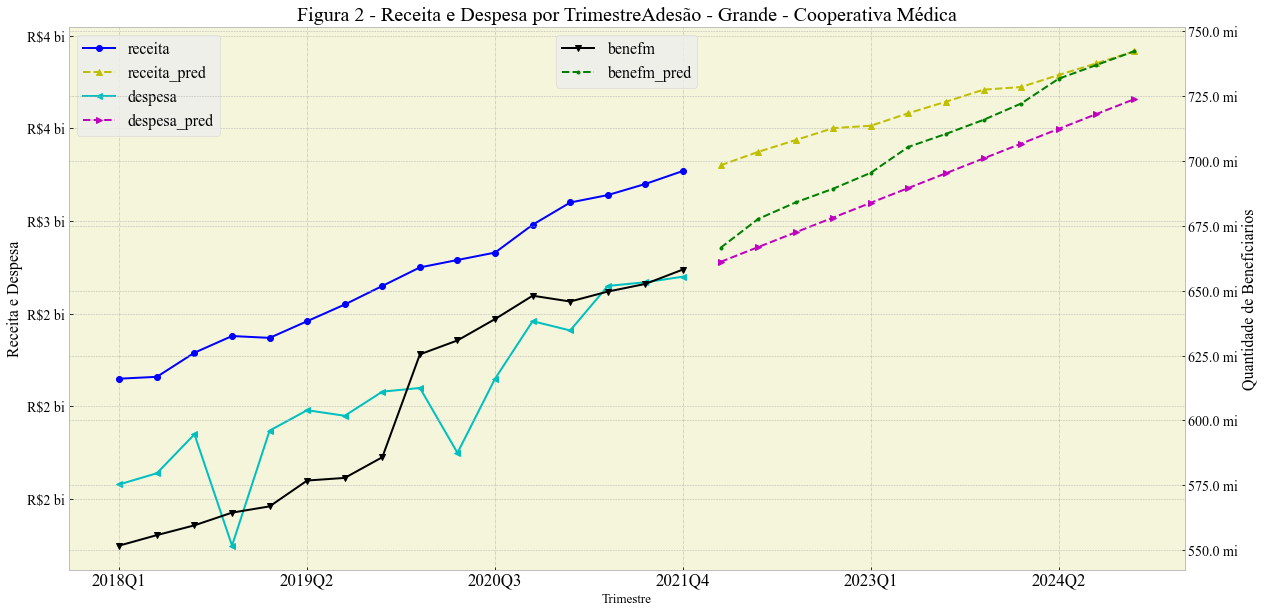

In [69]:
df_plot = ans_agrup_pred.copy()

#df_plot.set_index('trimestre', inplace=True)

fig,ax1 = plt.subplots()

df_plot.plot(y=['receita','receita_pred','despesa','despesa_pred'],figsize=(20, 10), style=['bo-','y^--','c<-','m>--'], ax=ax1)
ax1.set_title('Figura 2 - Receita e Despesa por Trimestre' + grupo, fontsize = 20)
#ax1.set_xticks(df_plot.index)
#ax1.set_xticklabels(df_plot.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} bi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita e Despesa', fontsize=16)
ax1.legend(loc = 'upper left', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')

ax2 = ax1.twinx()

df_plot.plot(y=['benefm', 'benefm_pred'], figsize=(20,10), style=['kv-','g.--'], ax=ax2)
#ax2.set_xticks(df_plot.index)
#ax2.set_xticklabels(df_plot.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
yticks = ax2.get_yticks()
ax2.set_yticklabels(['{:.1f} mi'.format(x/1e3) for x in yticks], fontsize = 14)
ax2.set_ylabel('Quantidade de Beneficiarios', fontsize=16)
ax2.legend(loc = 'upper center', fontsize = 16)

plt.savefig(grupo + '_svm_grid_pred.png',
 bbox_inches="tight",
 pad_inches=1,
 facecolor='w')


plt.show()

del df_plot